# Dataset analysis

In [1]:
from pathlib import Path
import pandas as pd

def append_row(df, row):
    return pd.concat([
                df,
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

result_df = pd.DataFrame(columns=['Normality', 'Generated Dataset', 'Length', 'Anomaly Points'])

directory = 'generated_data/'

for filepath in sorted(Path('generated_data').iterdir()):
  if filepath.is_file():
    name = filepath.name
    # Split the string at the first underscore
    parts = name.split("_", 1)

    # Assign the first part (normality2) to one variable and the rest (NAB_MGAB.out) to another
    normality = parts[0][-1]
    dataset = parts[1]

    df = pd.read_csv(filepath, header=None).dropna().to_numpy()

    max_length = len(df)

    label = df[:max_length, 1].astype(int)
    anomaly_points = list(label).count(1)

    new_row = pd.Series({'Normality': normality, 'Generated Dataset': dataset,
                         'Length': max_length, 'Anomaly Points': anomaly_points})

    result_df = pd.concat([
                result_df,
                pd.DataFrame([new_row], columns=new_row.index)]
           ).reset_index(drop=True)

result_df

Normality     Generated Dataset  Length Anomaly Points
0          1           Dodgers.out   50400           5612
1          1              MGAB.out  100000            200
2          1               NAB.out    4031            400
3          2      Dodgers_MGAB.out  150400           5812
4          2       Dodgers_NAB.out   54431           6012
5          2      MGAB_Dodgers.out  150400           5812
6          2          MGAB_NAB.out  104031            600
7          2       NAB_Dodgers.out   54431           6012
8          2          NAB_MGAB.out  104031            600
9          3  Dodgers_MGAB_NAB.out  154431           6212
10         3  Dodgers_NAB_MGAB.out  154431           6212
11         3  MGAB_Dodgers_NAB.out  154431           6212
12         3  MGAB_NAB_Dodgers.out  154431           6212
13         3  NAB_Dodgers_MGAB.out  154431           6212
14         3  NAB_MGAB_Dodgers.out  154431           6212

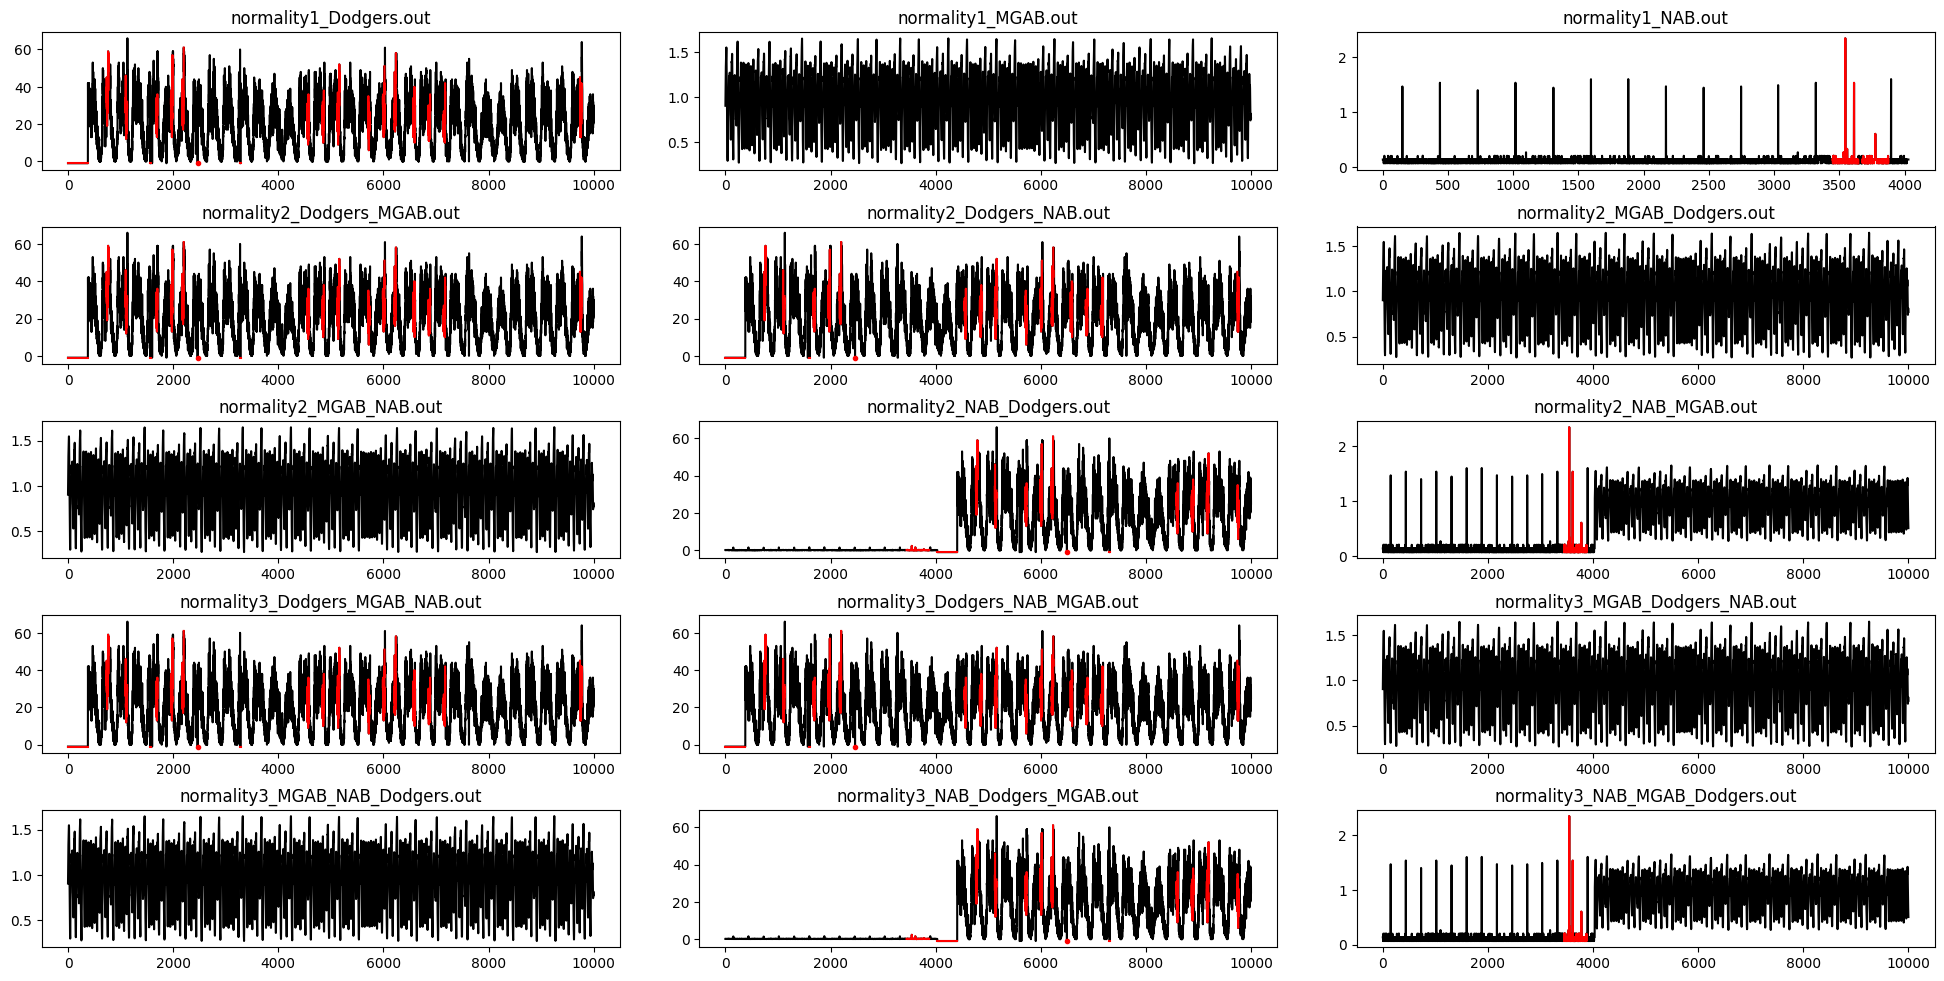

In [22]:
import matplotlib.pyplot as plt
from utils.metrics import metricor

directory = 'generated_data/'

# Create a 3x3 subplot figure
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=2.0)

i = 0
j = 0

grader = metricor()

for filepath in sorted(Path('generated_data').iterdir()):
  if filepath.is_file():
    name = filepath.name
    # Split the string at the first underscore
    parts = name.split("_", 1)

    # Assign the first part (normality2) to one variable and the rest (NAB_MGAB.out) to another
    normality = parts[0][-1]
    dataset = parts[1]

    df = pd.read_csv(filepath, header=None).dropna().to_numpy()

    max_length = 10000

    data = df[:max_length, 0].astype(float)
    label = df[:max_length, 1].astype(int)

    range_anomaly = grader.range_convers_new(label)
  
    axes[i, j].plot(data[:max_length],'k')
    axes[i, j].title.set_text(name)

    for r in range_anomaly:
        if r[0]==r[1]:
            axes[i, j].plot(r[0],data[r[0]],'r.')
        else:
            axes[i, j].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')

    j = (j + 1) % 3
    if j == 0: i += 1
            
            # axes[i, j].xlim(plotRange)

# IForest

## Variant 1
First we are going to run and see the results for the variant 1 of the iForest. Meaning that we just apply iForest in batches.
We are going to try four different values of batch size 1000, 1500, 2000, 2500, 3000.

In [3]:
import time
import os
import iforest_naive
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

directory = 'generated_data/'

result_df = pd.DataFrame(columns=['file_name', 'batch_size', 'AUC', 'time'])

for batch_size in [1000, 1500, 2000, 2500, 3000]:  # batch_size
    for filepath in sorted(Path(directory).iterdir()):
        if filepath.is_file():
            model = iforest_naive.IsolationForestNaiveStream()
            name = filepath.name
            df = pd.read_csv(filepath, header=None).dropna().to_numpy()

            max_length = len(df)

            data = df[:max_length, 0].astype(float)
            label = df[:max_length, 1].astype(int)

            # fit the model
            start_time = time.time()
            model.fit(data, init_length=1000, batch_size=batch_size)  # fit to 1000 first data first
            total_time = time.time() - start_time

            score = model.decision_scores_
            score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
            auc = metrics.roc_auc_score(label, score)

            new_row = {
                       'file_name': name,
                       'batch_size': batch_size,
                       'AUC': auc,
                       'time': total_time}

            result_df.loc[len(result_df)] = new_row

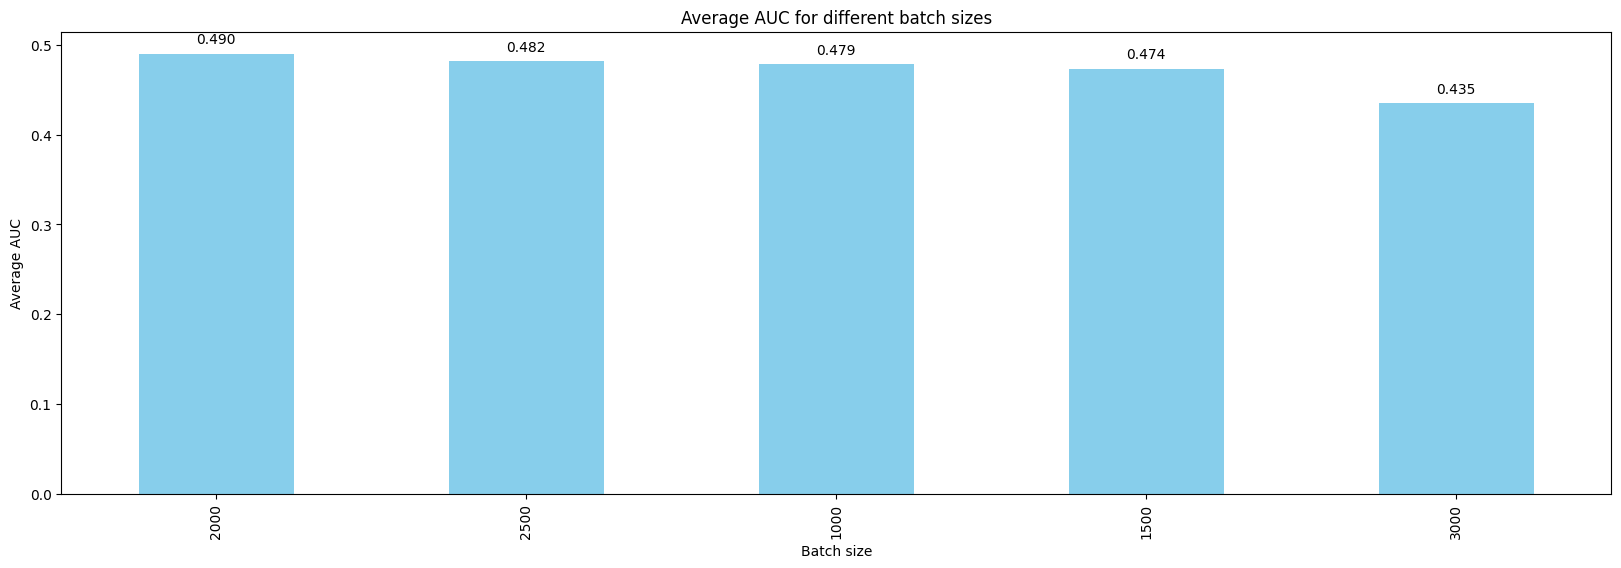

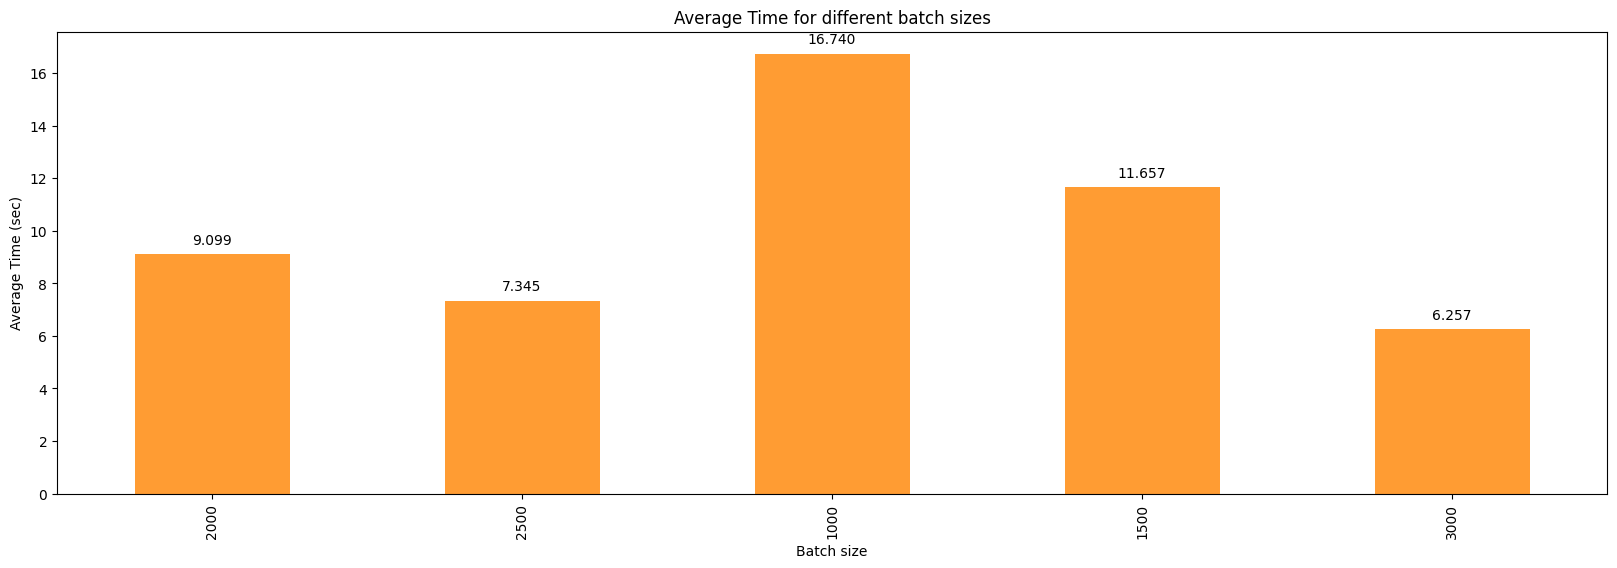

In [24]:
import matplotlib.pyplot as plt
# group by the batch_size columns and calculate the mean of AUC and time
grouped_df = result_df.groupby(['batch_size']).agg({'AUC': 'mean', 'time': 'mean'}).reset_index()

# set the index to the new label column
grouped_df.set_index('batch_size', inplace=True)

# sort the data frame by AUC column
sorted_ROC = grouped_df.sort_values(by=['AUC'], ascending=[False])

# set labels for the plot
ax1 = sorted_ROC['AUC'].plot(kind='bar', figsize=(20, 6), color='skyblue', legend=False)
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Average AUC')
ax1.set_title('Average AUC for different batch sizes')

# show for each bar its value
for p in ax1.patches:
  # color = 'red' if p.get_height() == roc_max_value else 'black'
  # weight = 'bold' if p.get_height() == roc_max_value else 'normal'
  ax1.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()

# Sort the DataFrame by ROC and time
sorted_time = grouped_df.sort_values(by=['AUC', 'time'], ascending=[False, True])

# Select the top 20 rows
top20_df = sorted_time.head(20)

# Plot the average time
ax2 = sorted_ROC['time'].plot(kind='bar', figsize=(20, 6), color='#ff9c33', legend=False)
ax2.set_xlabel('Batch size')
ax2.set_ylabel('Average Time (sec)')
ax2.set_title('Average Time for different batch sizes')

for p in ax2.patches:
  # color = 'red' if p.get_height() == roc_max_value else 'black'
  # weight = 'bold' if p.get_height() == roc_max_value else 'normal'
  ax2.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()


The highest average AUC has the implementation with batch size equal to 2000.

## Variant 2

Below we are going to run our optimal iforest algorithm. We are going to try different values for the available parameters. In order to do that we are going to use the two helper functions ```run_without_init_training``` and ```run_with_init_training``` from the statistics class.
The ```run_with_init_training``` involved training the model on a fixed, predetermined number of data points (1000), before using the sliding window approach. 
The ```run_without_init_training``` just uses the sliding window approach without any initial training.
The results of the execution will be stored in the file results/result.txt

In [ ]:
from utils import statitstics

statitstics.run_without_init_training()
statitstics.run_with_init_training()

Now we are going to plot all the possible combinations of the different values for:
* window_size: the size of the window to process each time
* anomaly_threshold: if the anomaly score of a point is greater than the anomaly_threshold value then the point is considered an anomaly
* drift_threshold: used to decide if the model is going to be retrained, if the current anomaly rate is higher than the drift_threshold then the model gets retrained.
* init_training: true if the model has been trained on an initial number of points or else false

Our goal is to find which one has the highest AUC value.

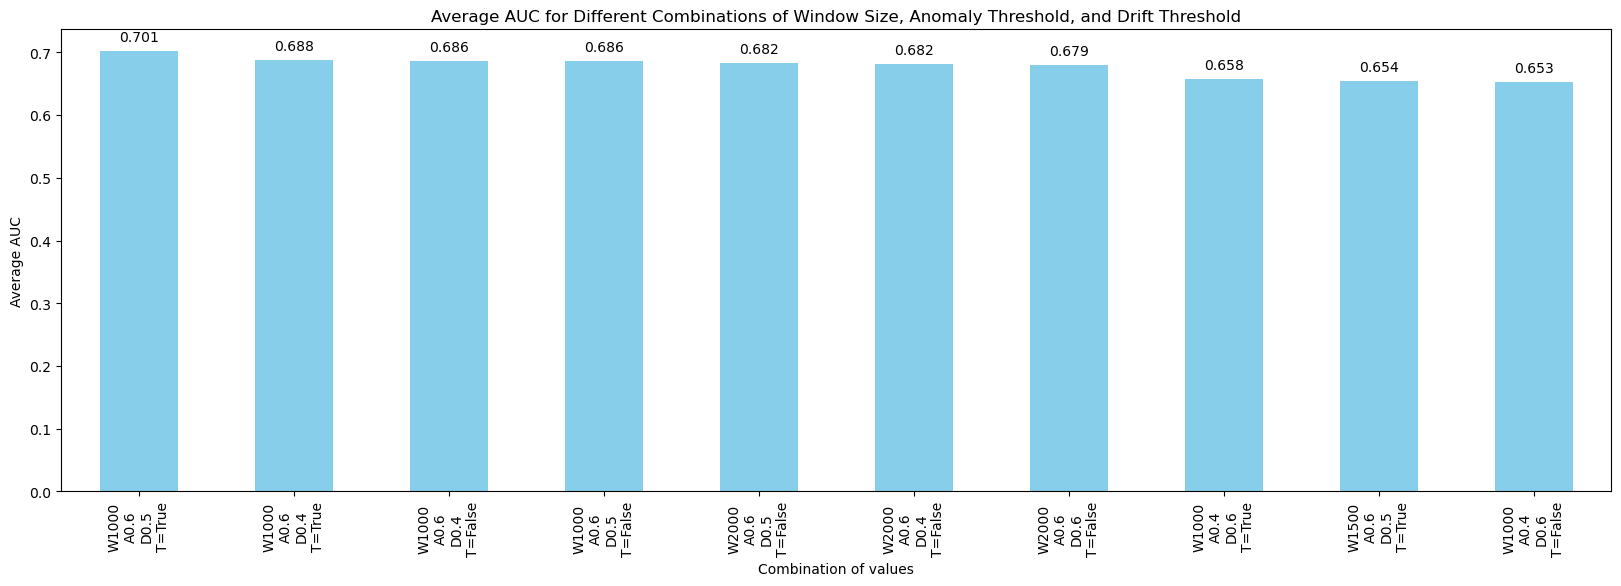

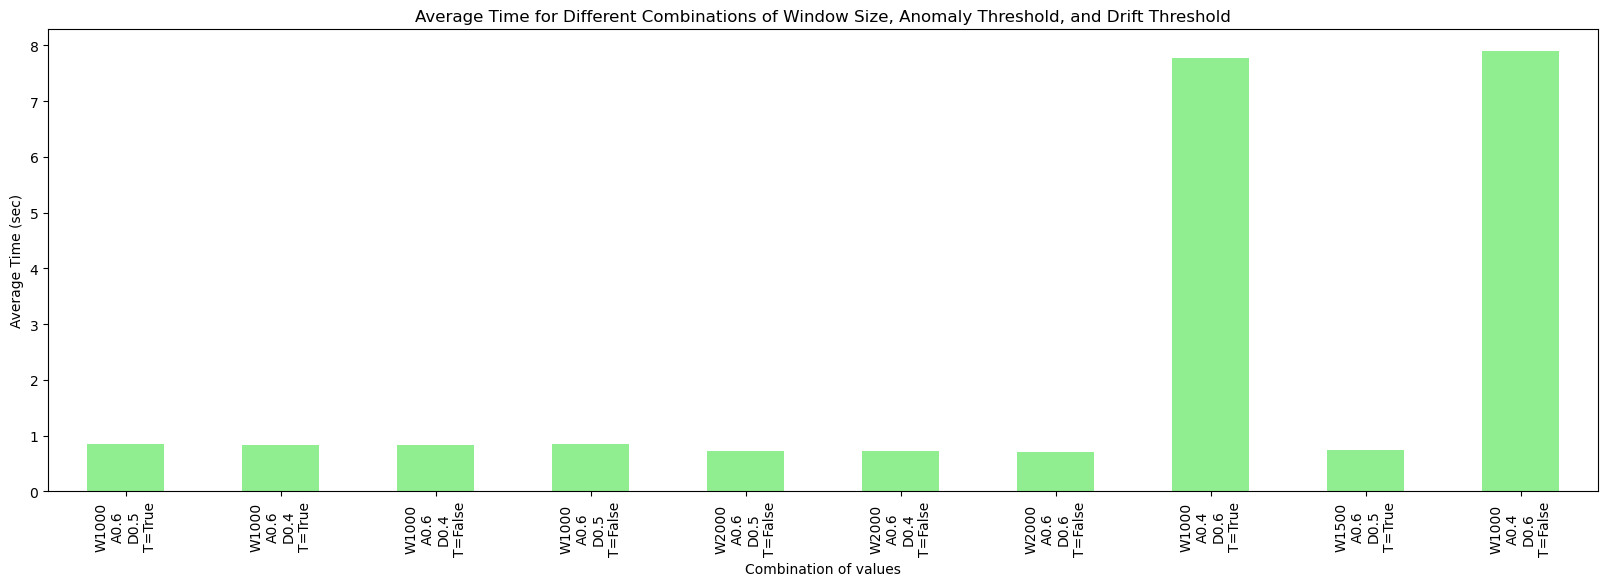

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# load the data from the result.txt file into a pandas data frame
file_path = 'results/result.txt'
df = pd.read_csv(file_path)

# create a new column combining window_size, anomaly_threshold, drift_threshold and training
df['window_anomaly_drift_training'] = df.apply(lambda row: f'W{row.window_size}_A{row.anomaly_threshold}_D{row.drift_threshold}_Τ{row.init_training}', axis=1)

# group by the above columns and calculate the mean of AUC and time
grouped_df = df.groupby(['window_size', 'anomaly_threshold', 'drift_threshold', 'init_training']).agg({'AUC': 'mean', 'time': 'mean'}).reset_index()

# ------- Plot the results ------
# create a new column for the plot's labels containg all the columns we want to test
grouped_df['window_anomaly_drift_training'] = grouped_df.apply(lambda row: f'W{row.window_size}\nA{row.anomaly_threshold}\nD{row.drift_threshold}\nT={row.init_training}', axis=1)

# set index to the created column
grouped_df.set_index('window_anomaly_drift_training', inplace=True)

# sort data frame by AUC in an descending order
sorted_AUC = grouped_df.sort_values(by=['AUC'], ascending=[False])

# get the top 20 rows
top20_df = sorted_AUC.head(10)

# plot the average AUC
ax1 = top20_df['AUC'].plot(kind='bar', figsize=(20, 6), color='skyblue', legend=False)
ax1.set_xlabel('Combination of values')
ax1.set_ylabel('Average AUC')
ax1.set_title('Average AUC for Different Combinations of Window Size, Anomaly Threshold, and Drift Threshold')

# set labels for each plot bar
for p in ax1.patches:
  ax1.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()


# sort data frame by AUC in an descending order and time in ascending
sorted_time = grouped_df.sort_values(by=['AUC', 'time'], ascending=[False, True])

# get the top 20 rows
top20_df = sorted_time.head(10)

# plot the average time
ax2 = top20_df['time'].plot(kind='bar', figsize=(20, 6), color='lightgreen', legend=False)
ax2.set_xlabel('Combination of values')
ax2.set_ylabel('Average Time (sec)')
ax2.set_title('Average Time for Different Combinations of Window Size, Anomaly Threshold, and Drift Threshold')
plt.show()

## Optimal vs Naive
Now, we are going to run both our implementations to all the files, with the best parameters.

generated_data\normality1_Dodgers.out


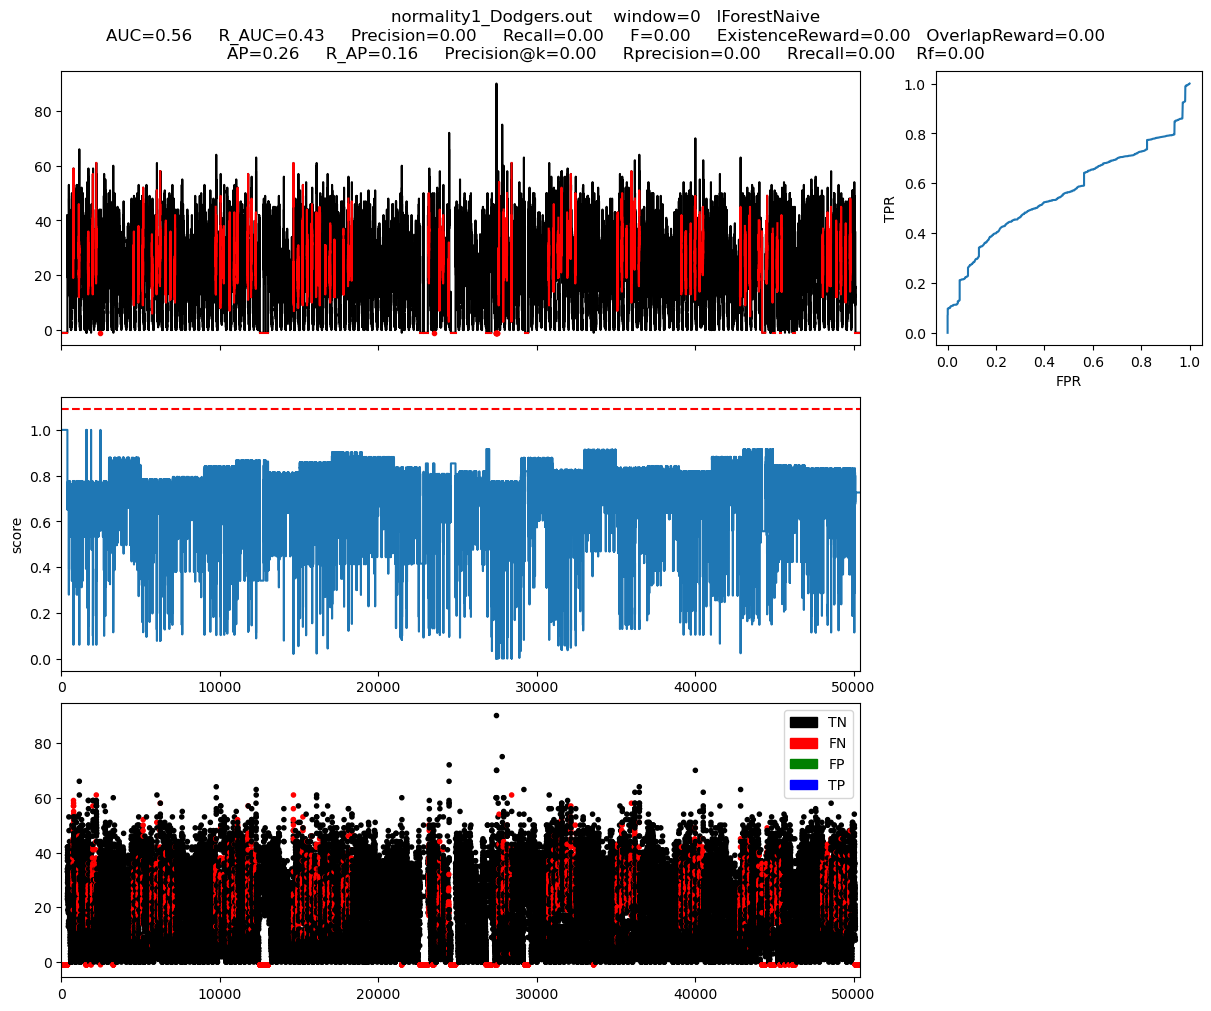

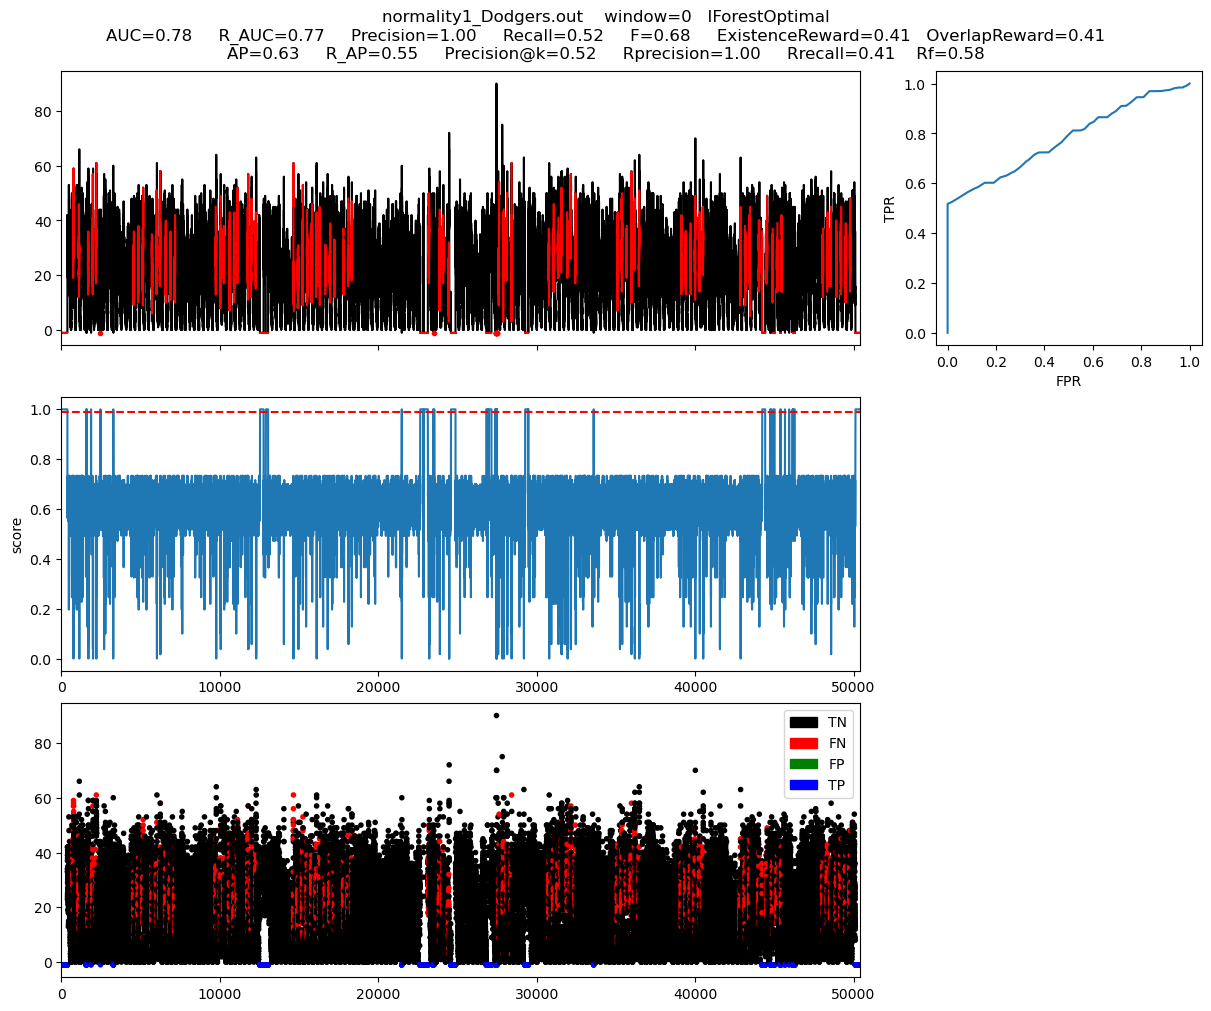



generated_data\normality1_MGAB.out


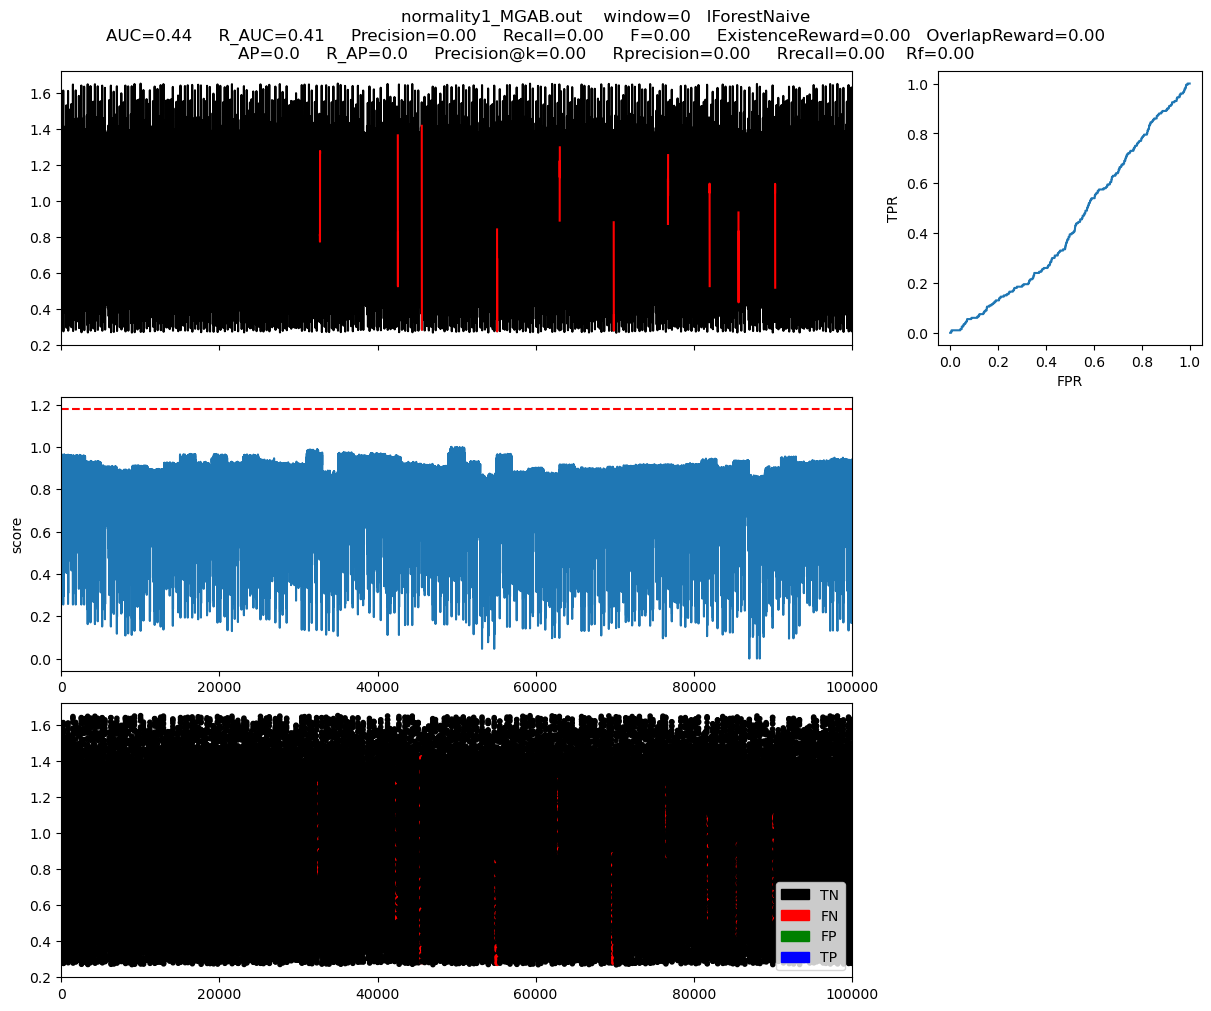

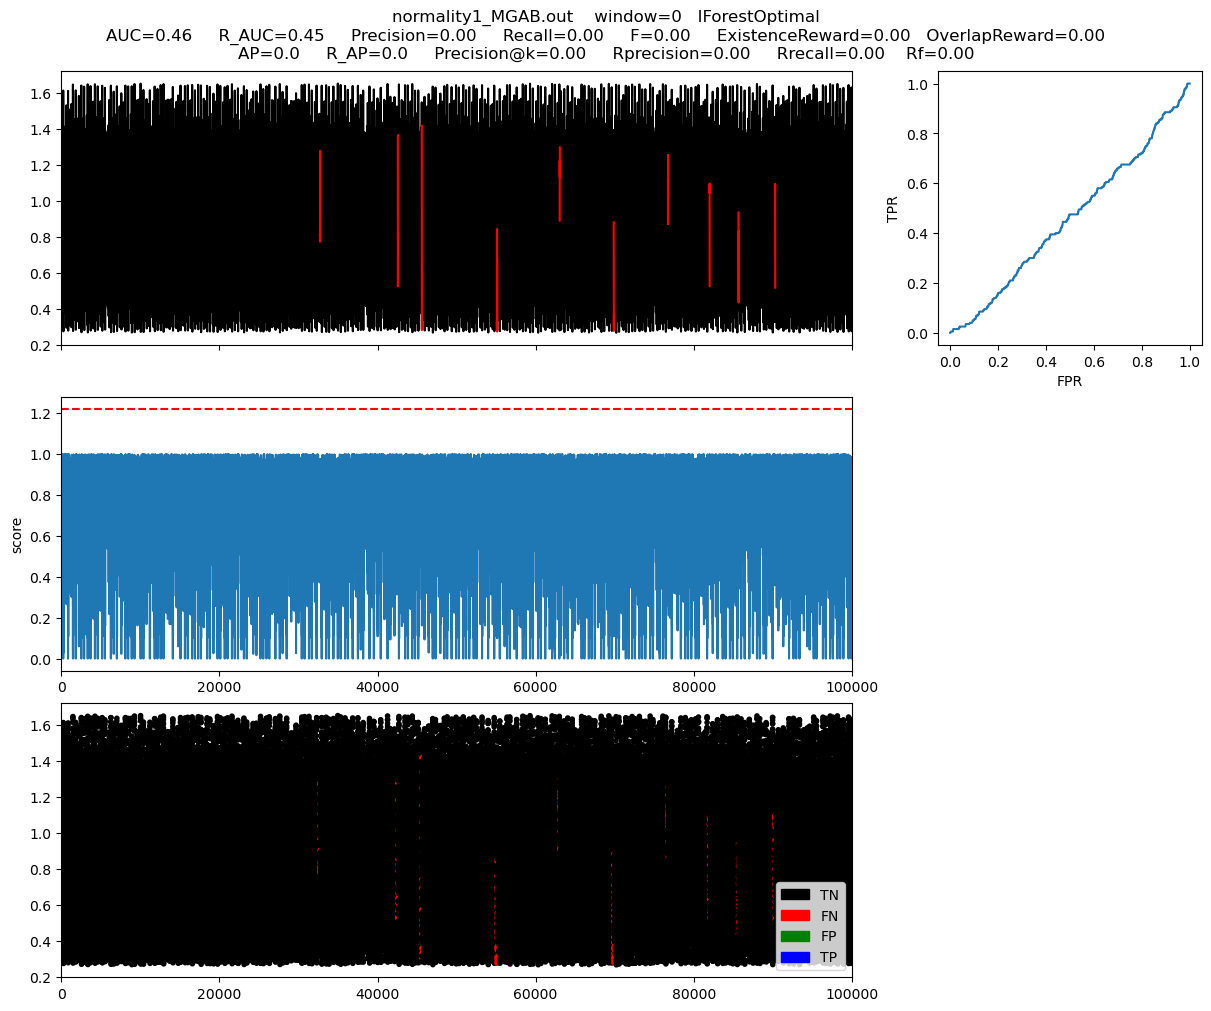



generated_data\normality1_NAB.out


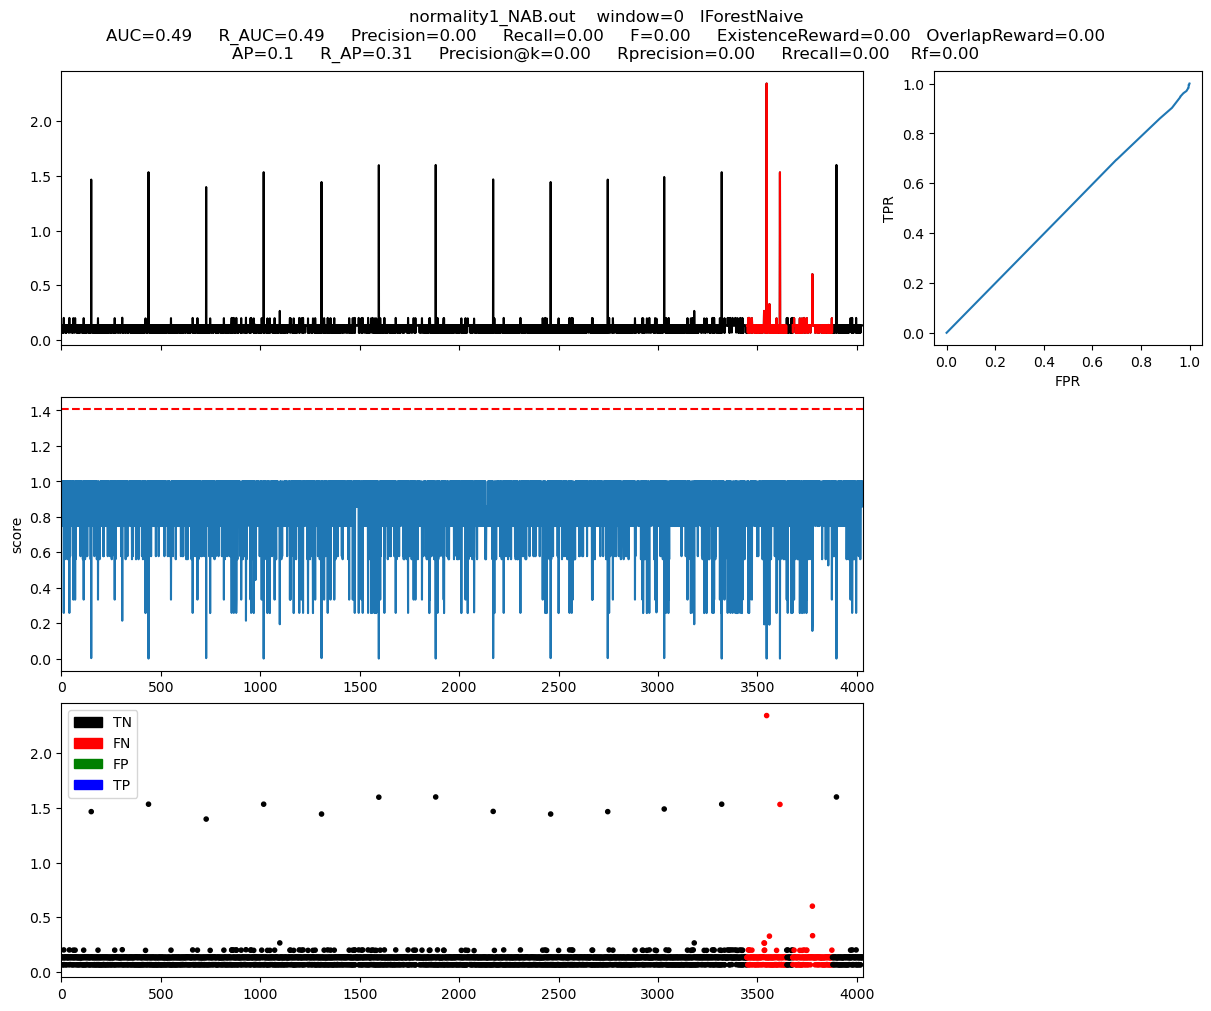

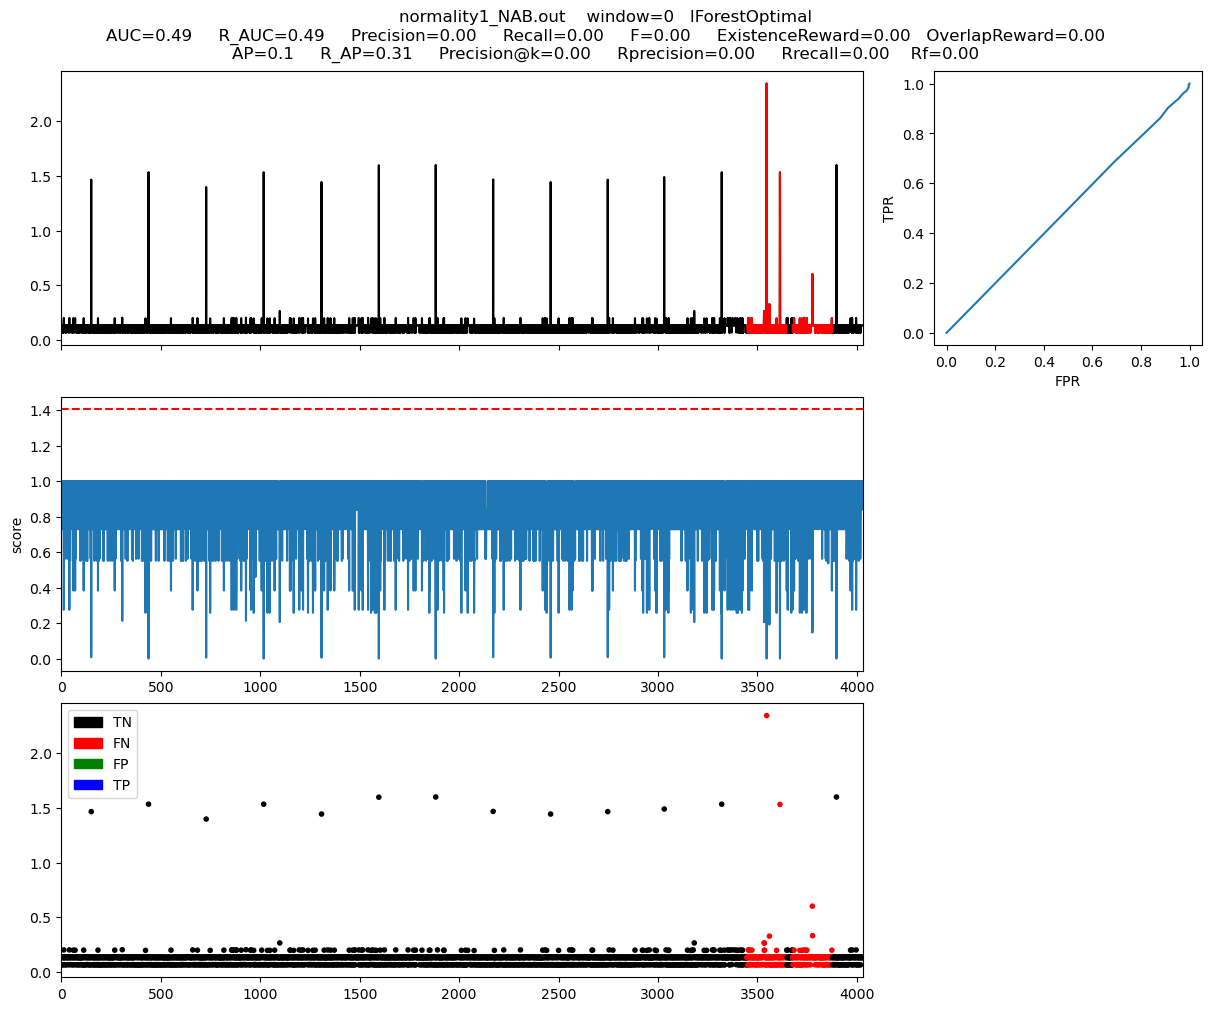



generated_data\normality2_Dodgers_MGAB.out


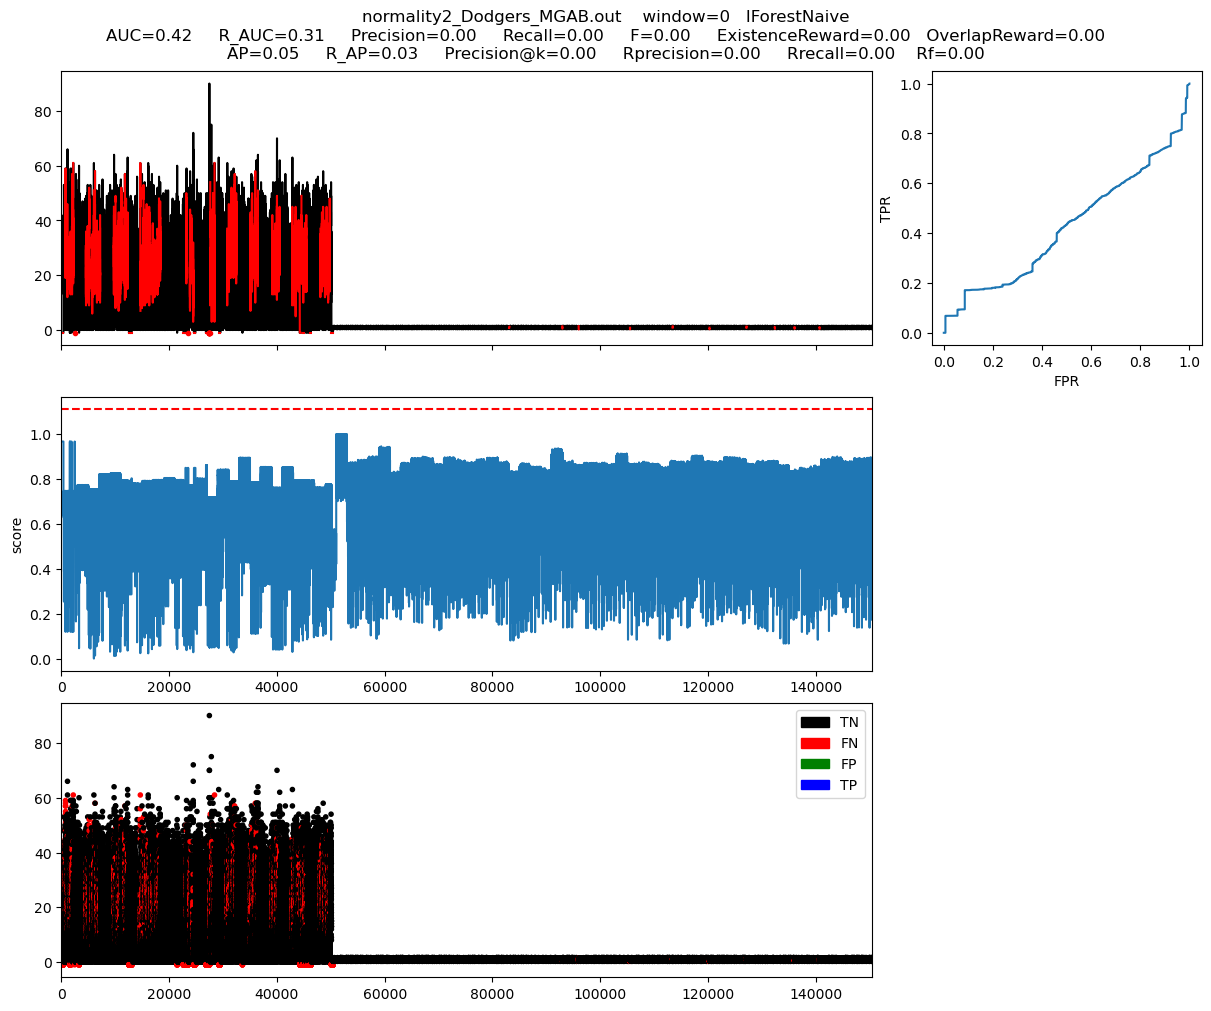

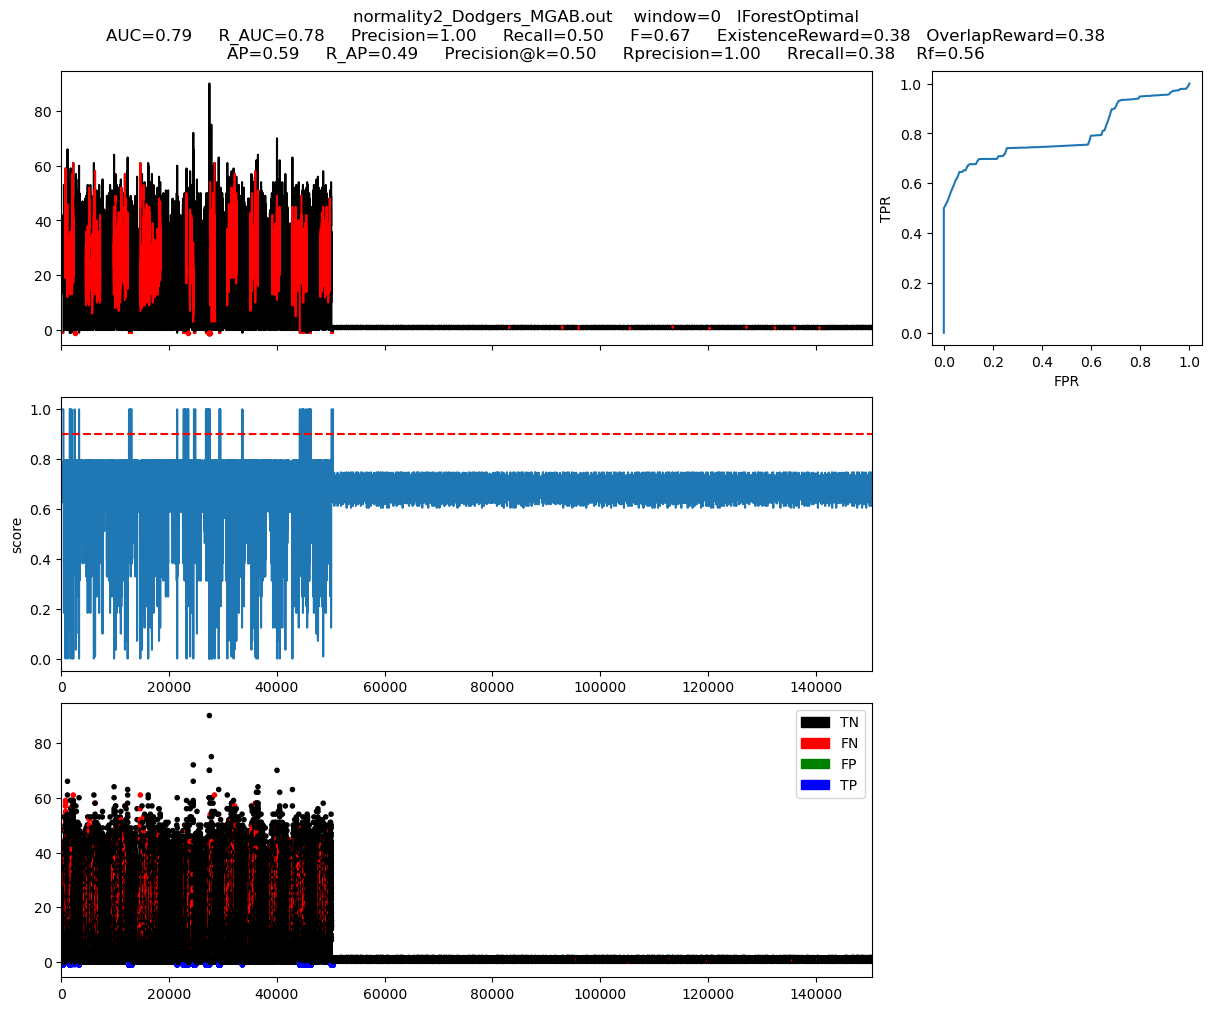



generated_data\normality2_Dodgers_NAB.out


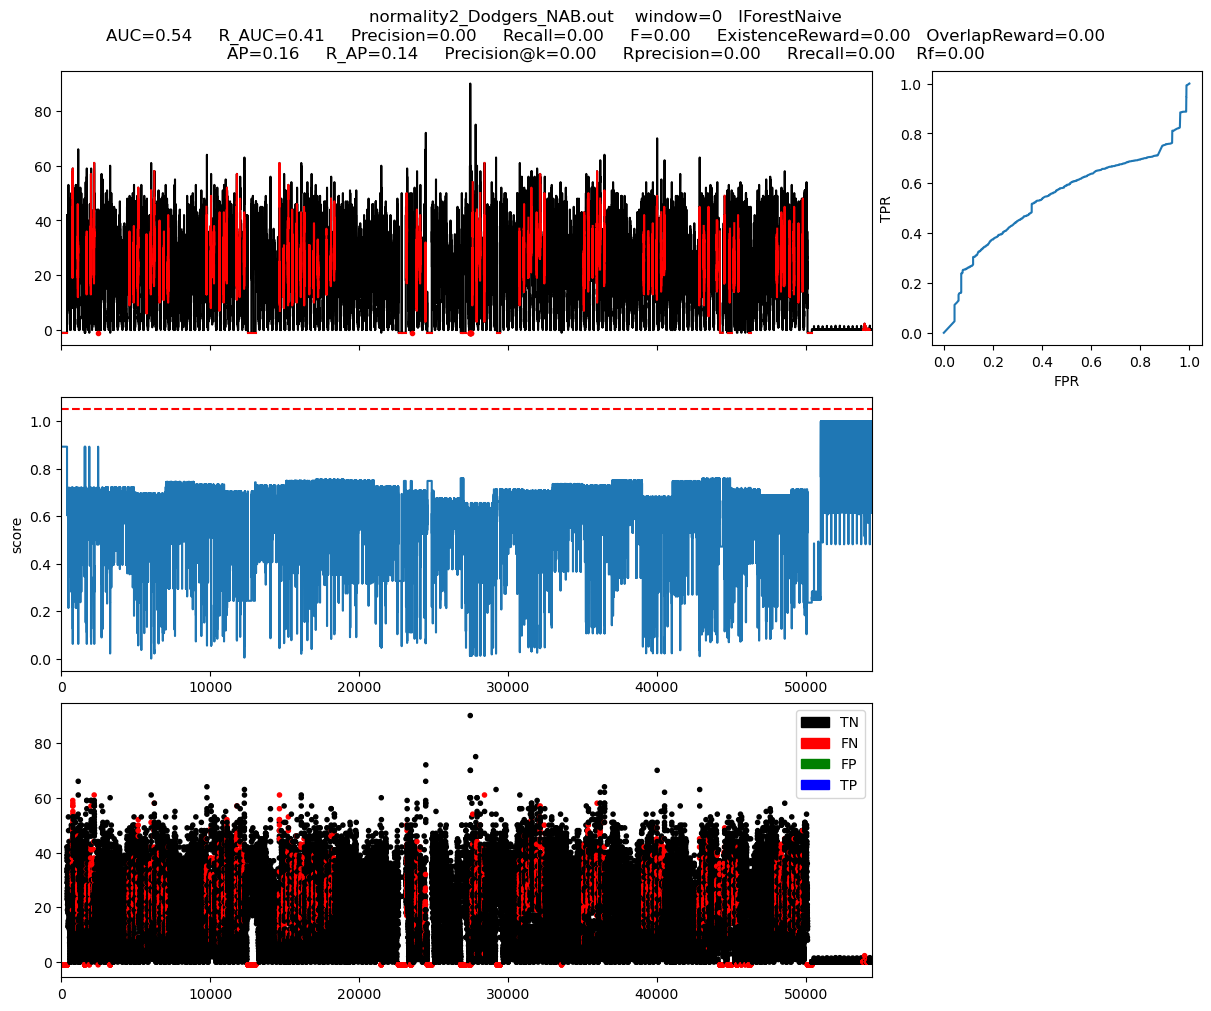

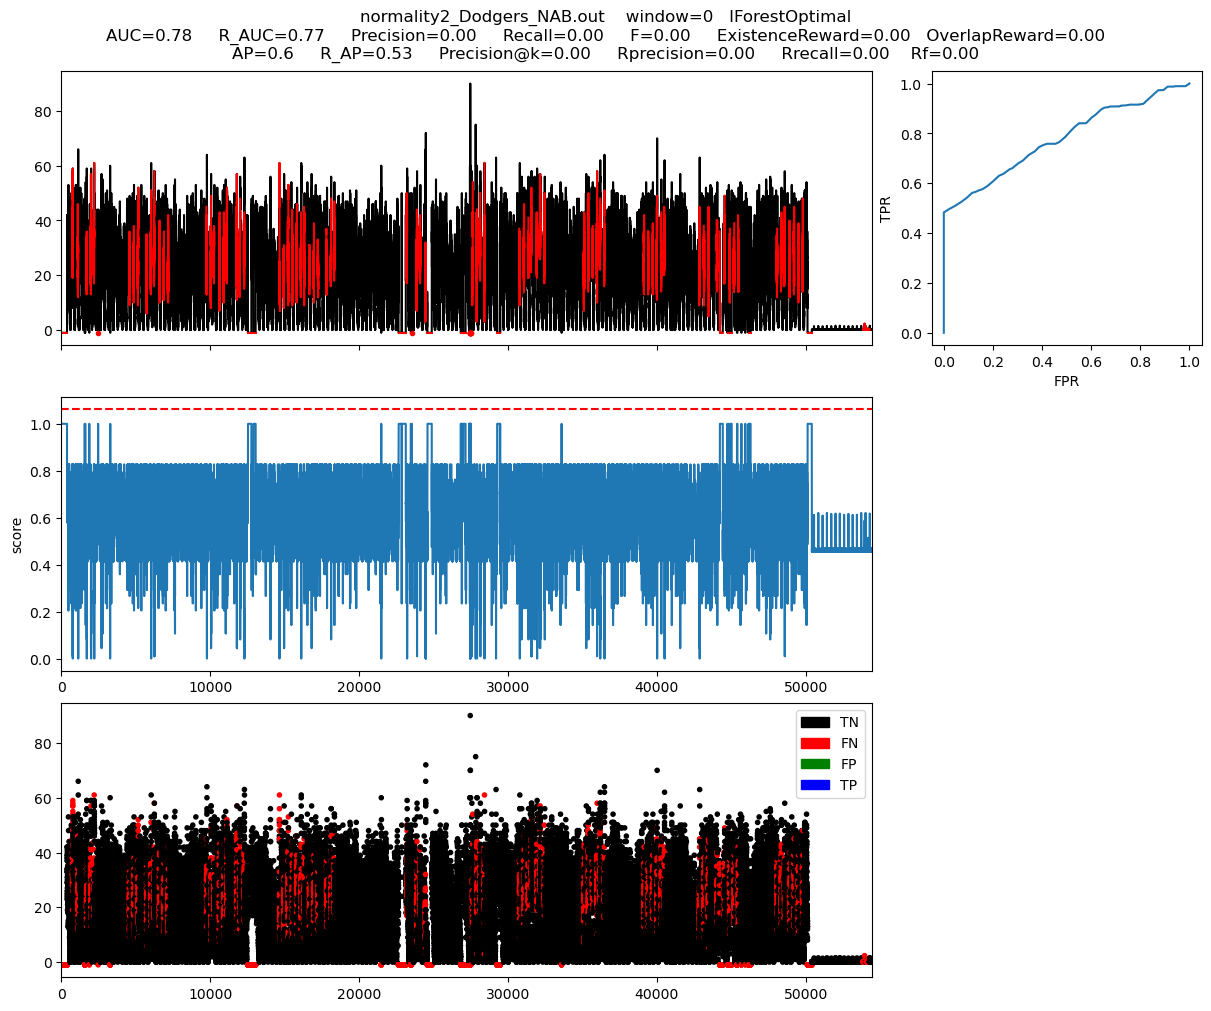



generated_data\normality2_MGAB_Dodgers.out


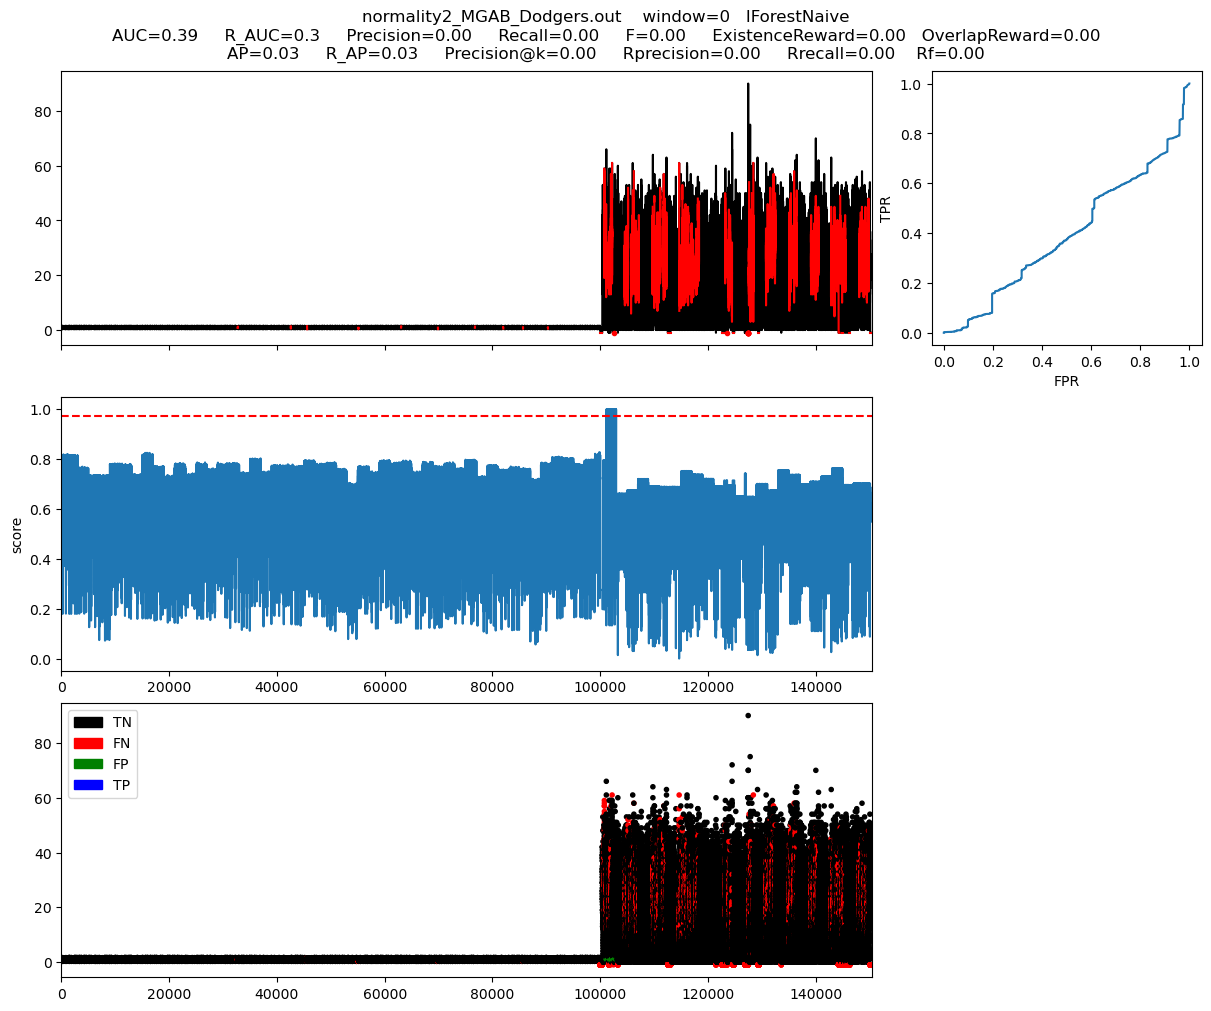

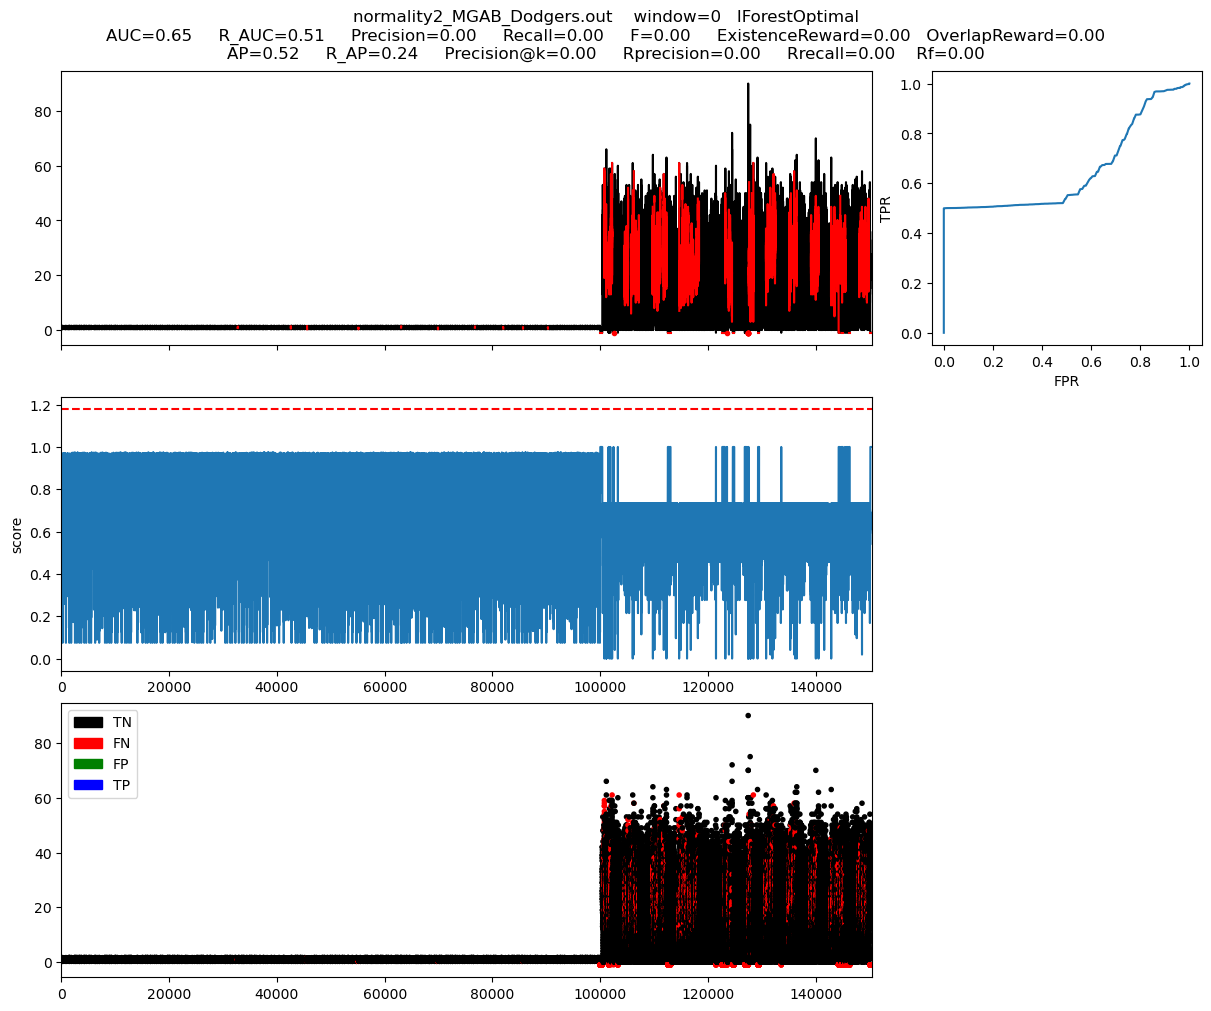



generated_data\normality2_MGAB_NAB.out


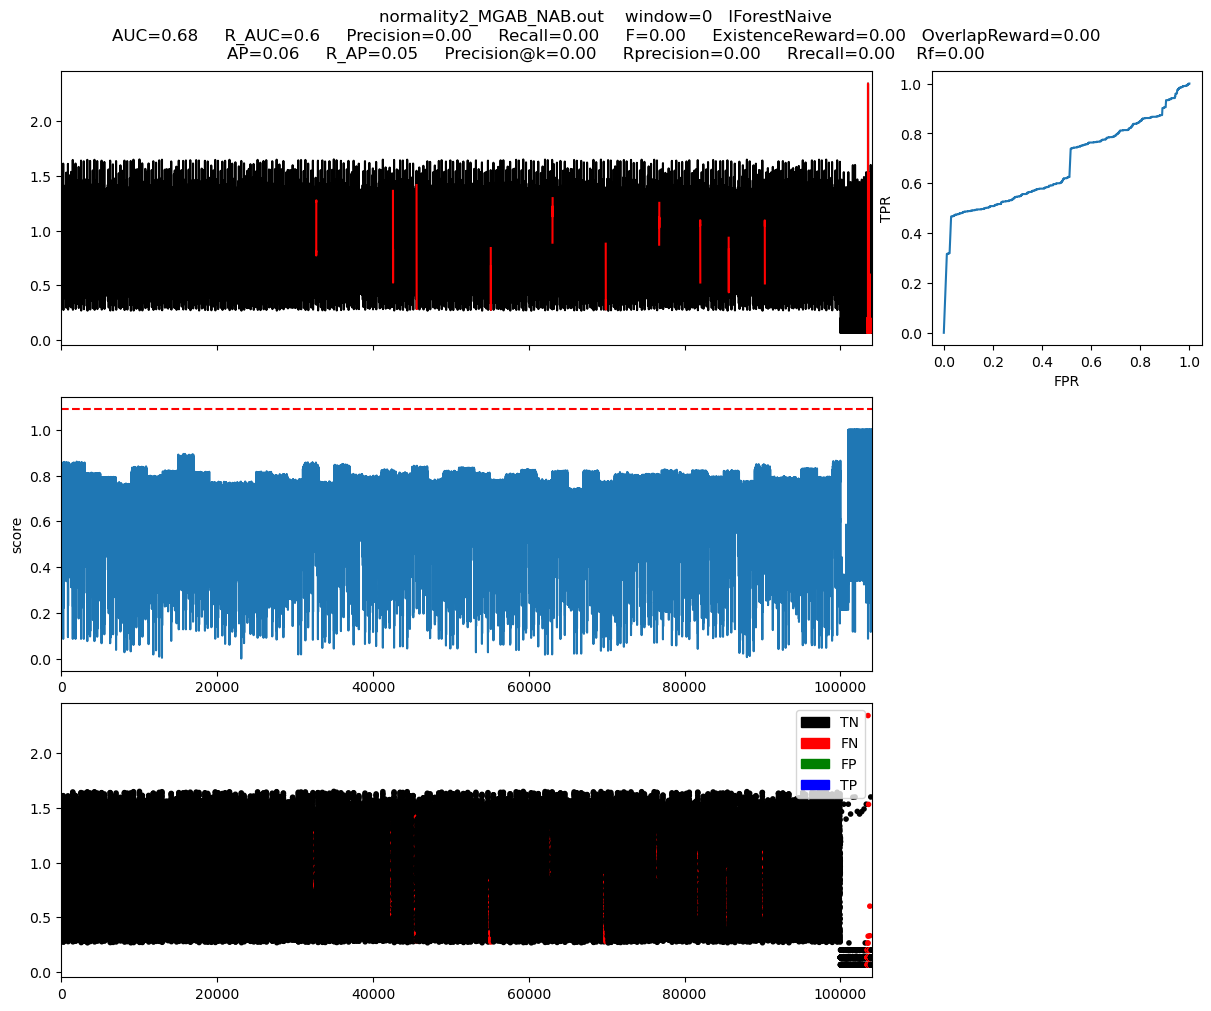

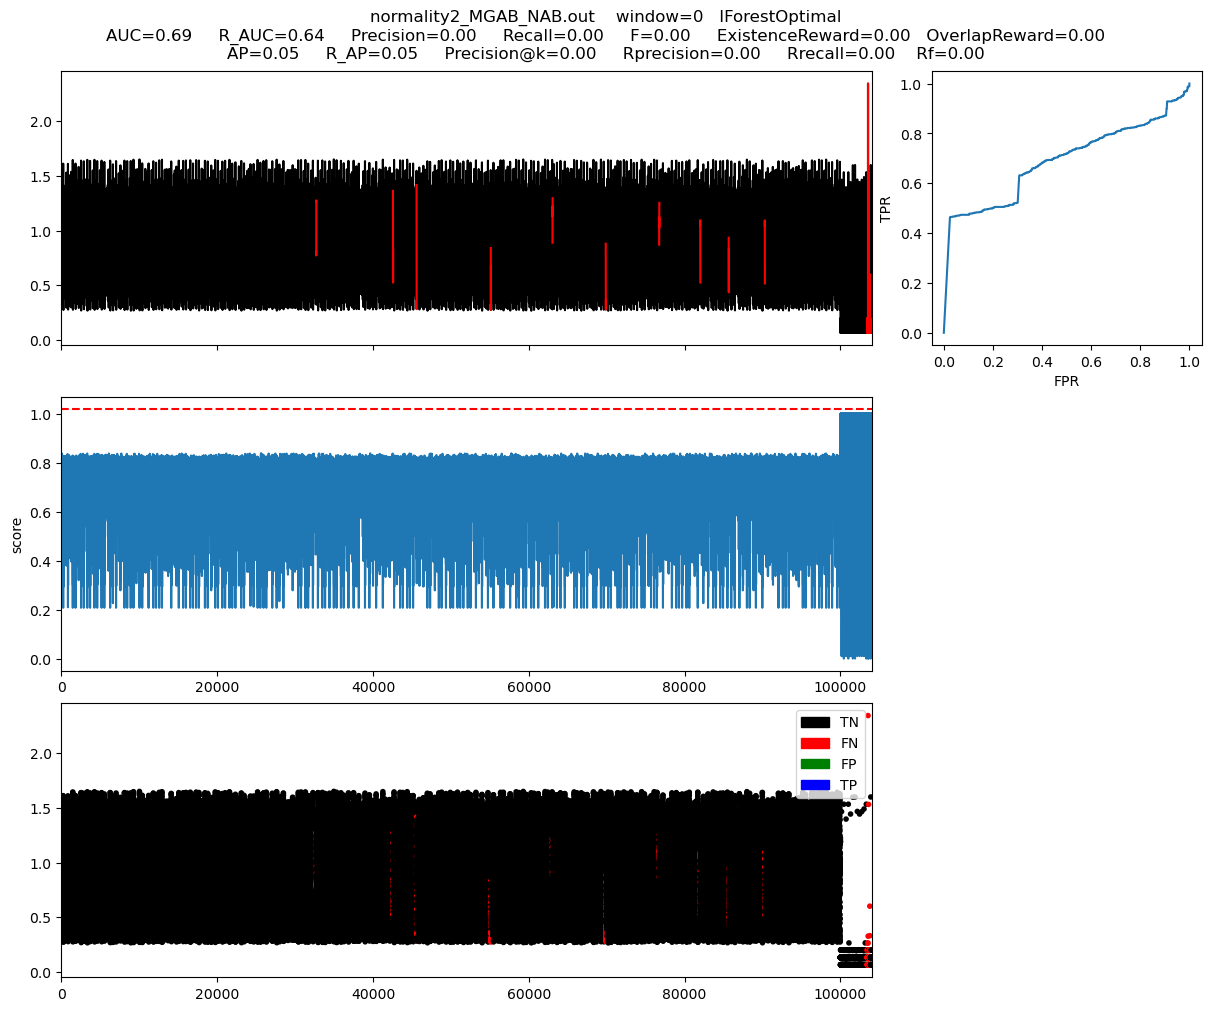



generated_data\normality2_NAB_Dodgers.out


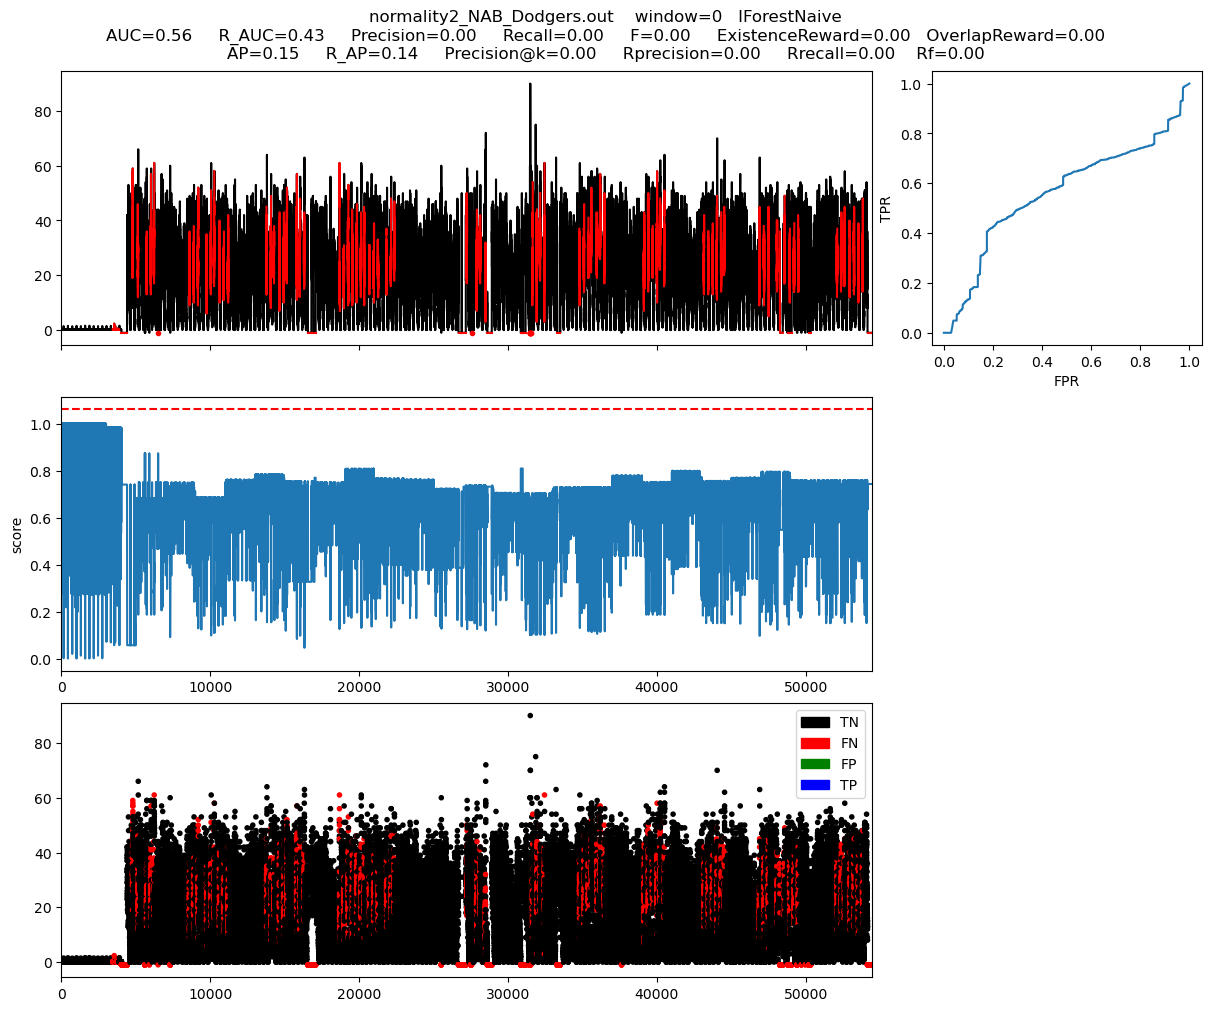

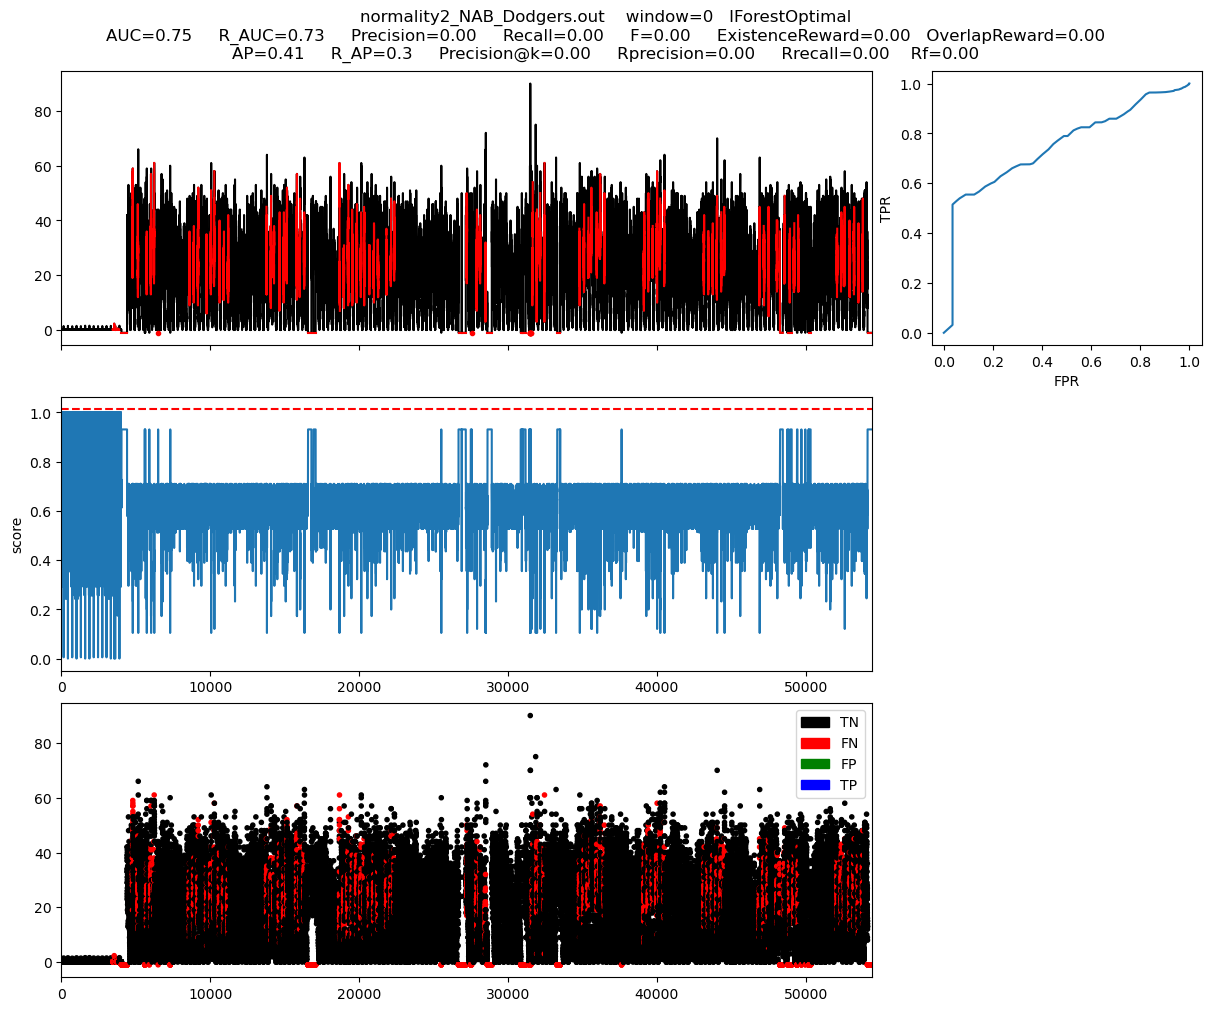



generated_data\normality2_NAB_MGAB.out


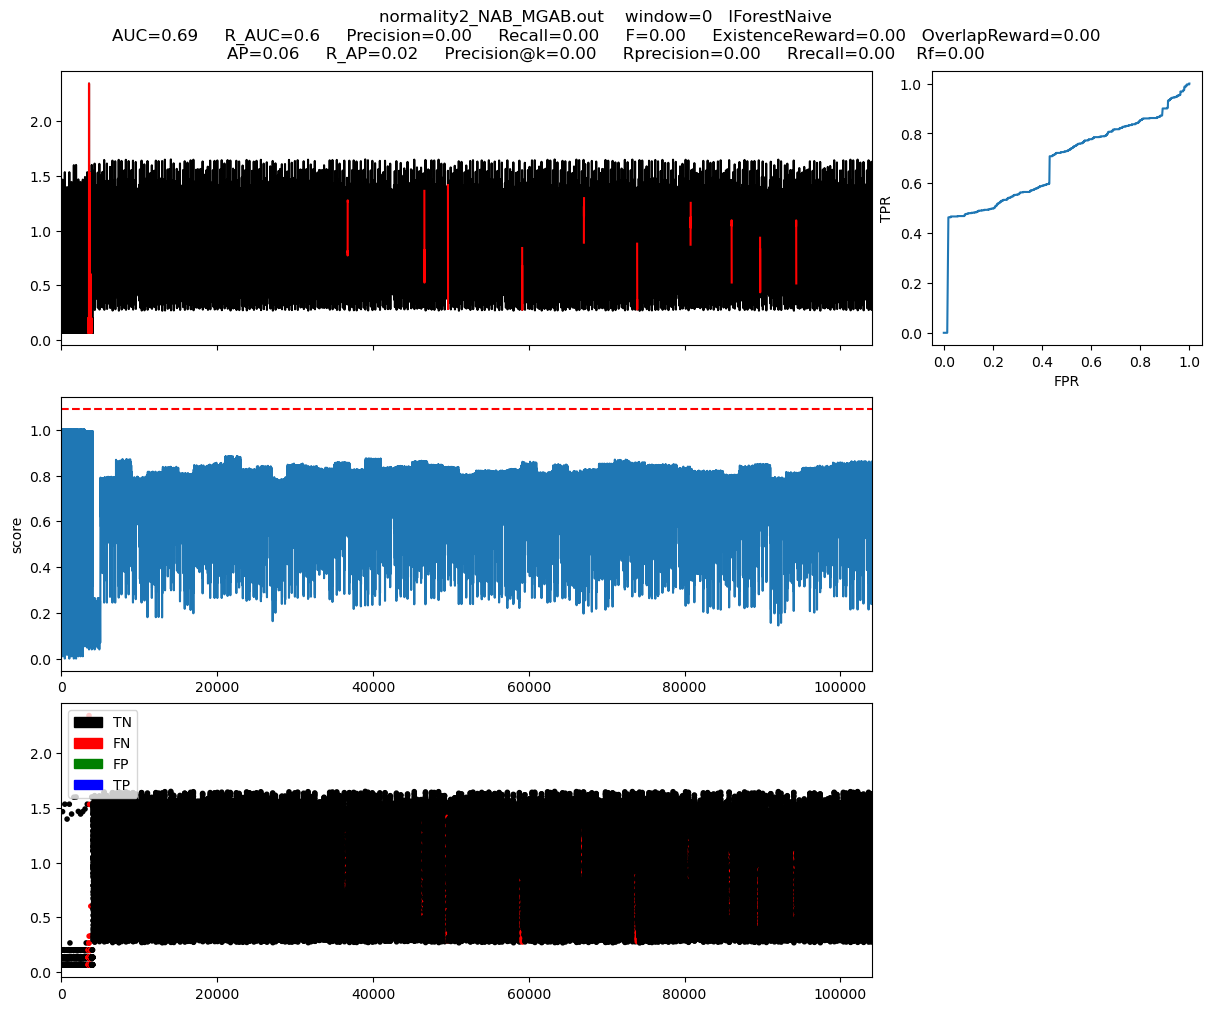

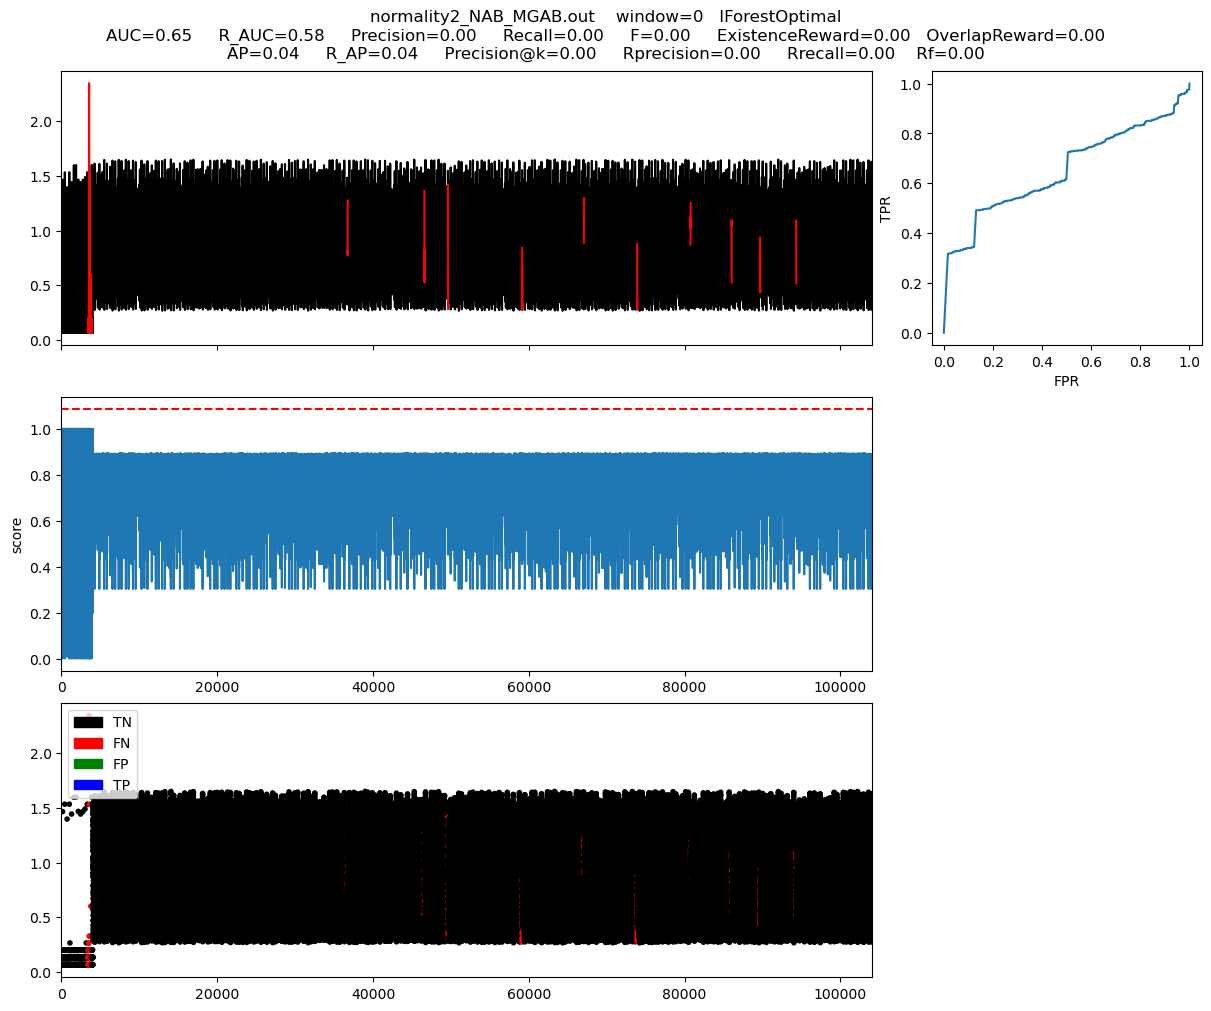



generated_data\normality3_Dodgers_MGAB_NAB.out


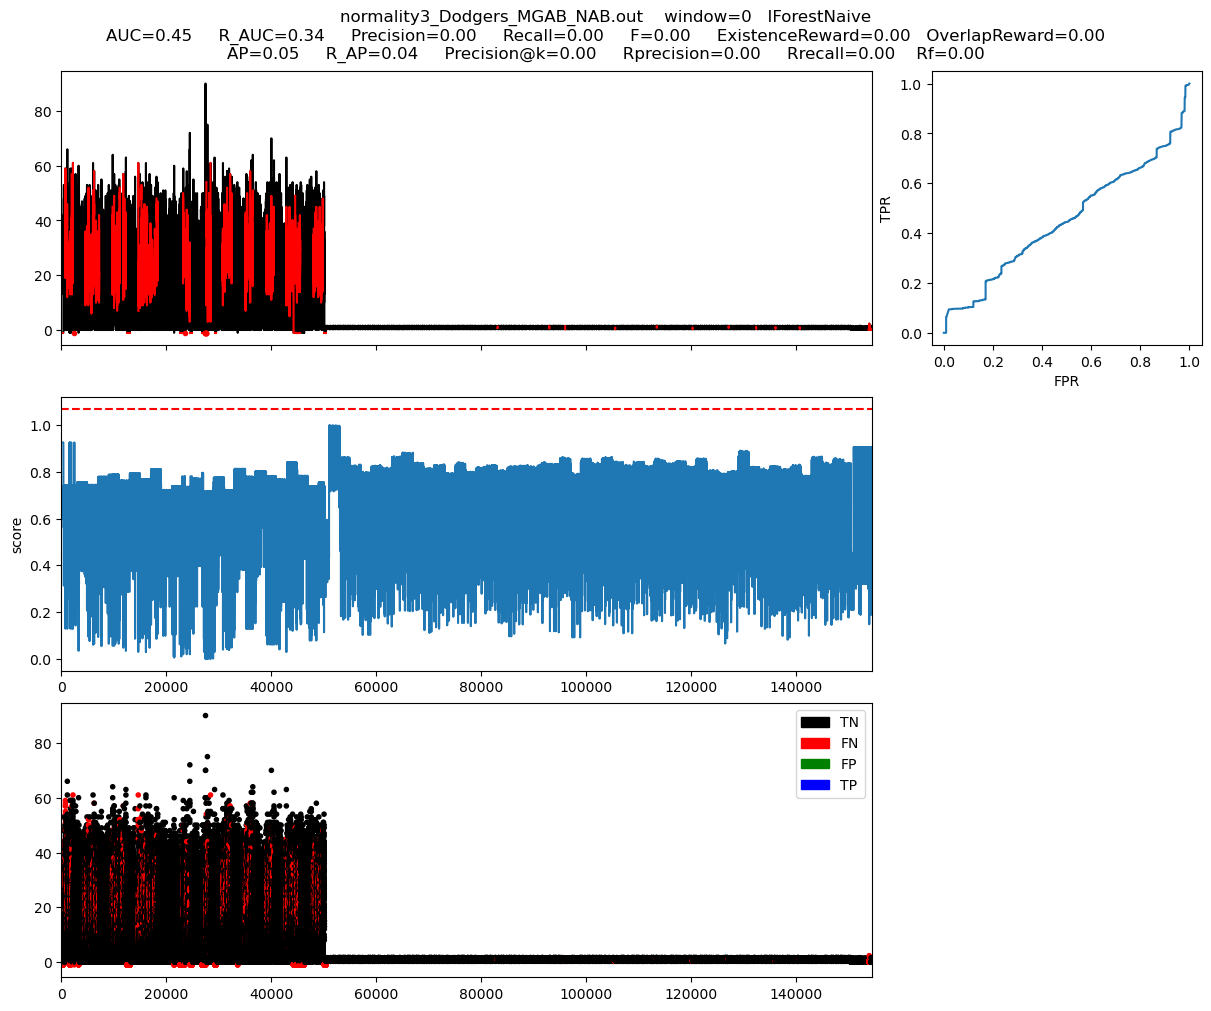

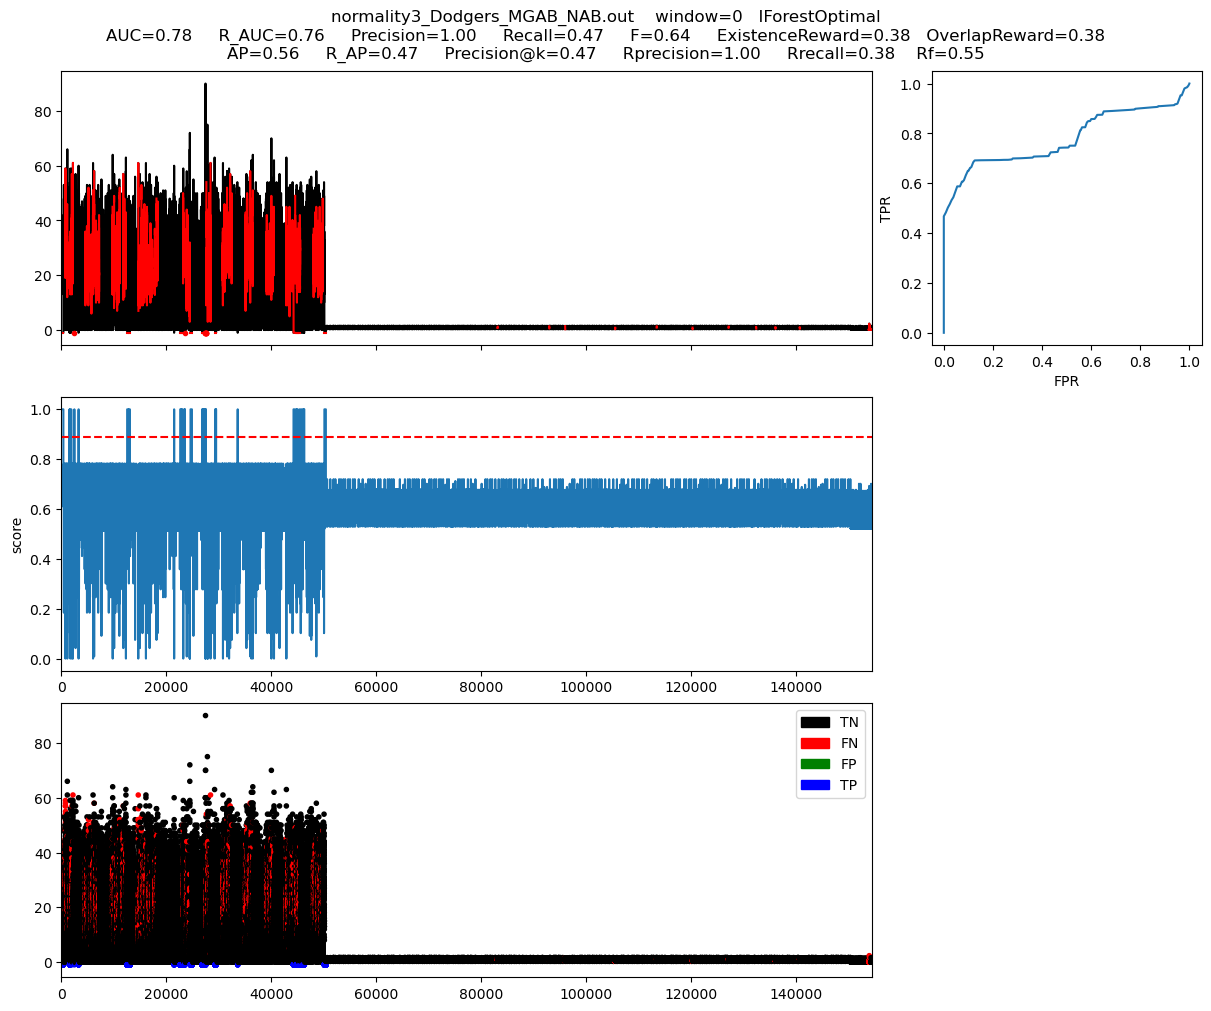



generated_data\normality3_Dodgers_NAB_MGAB.out


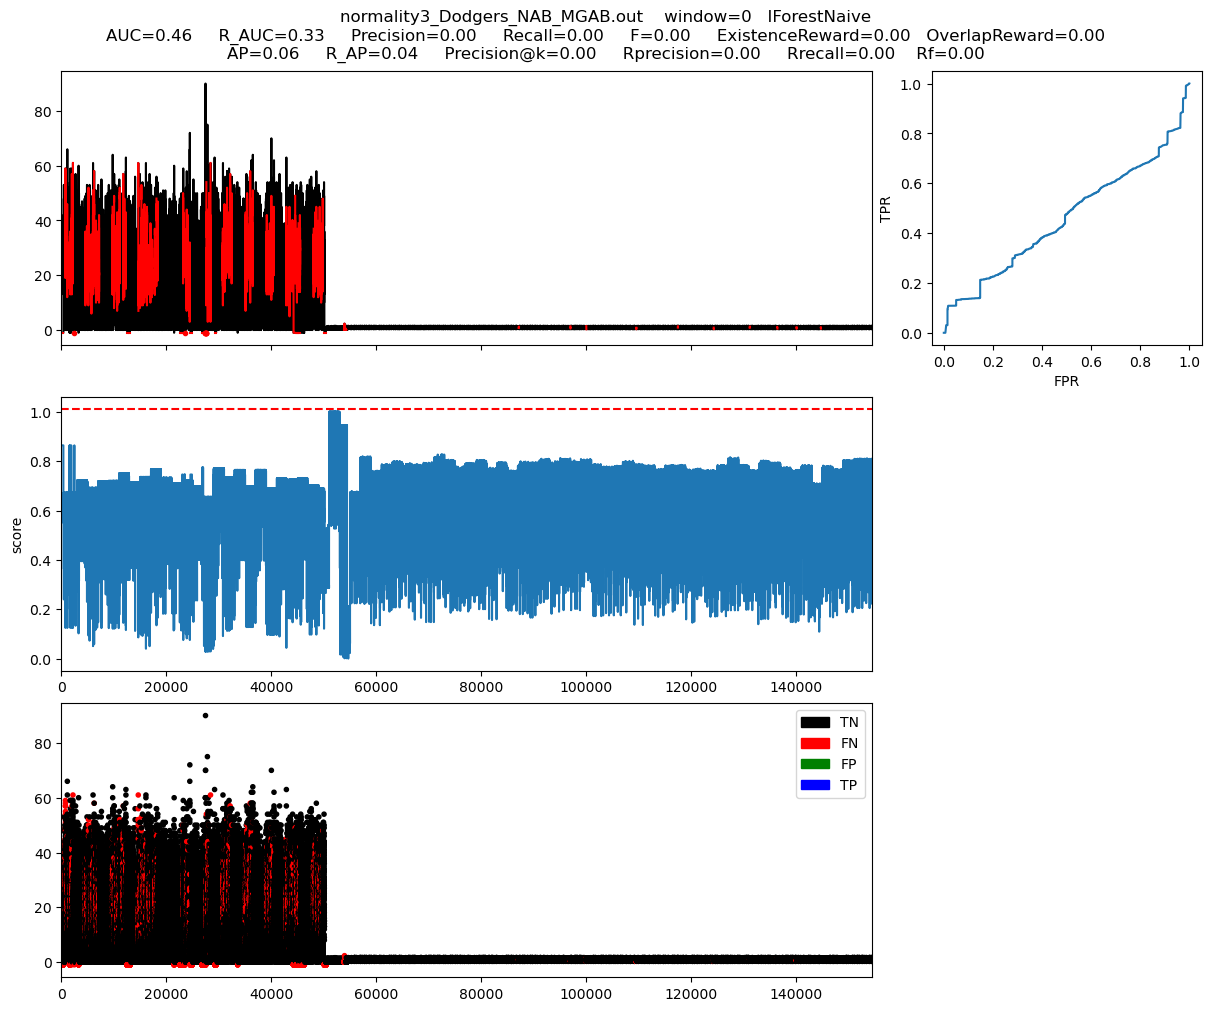

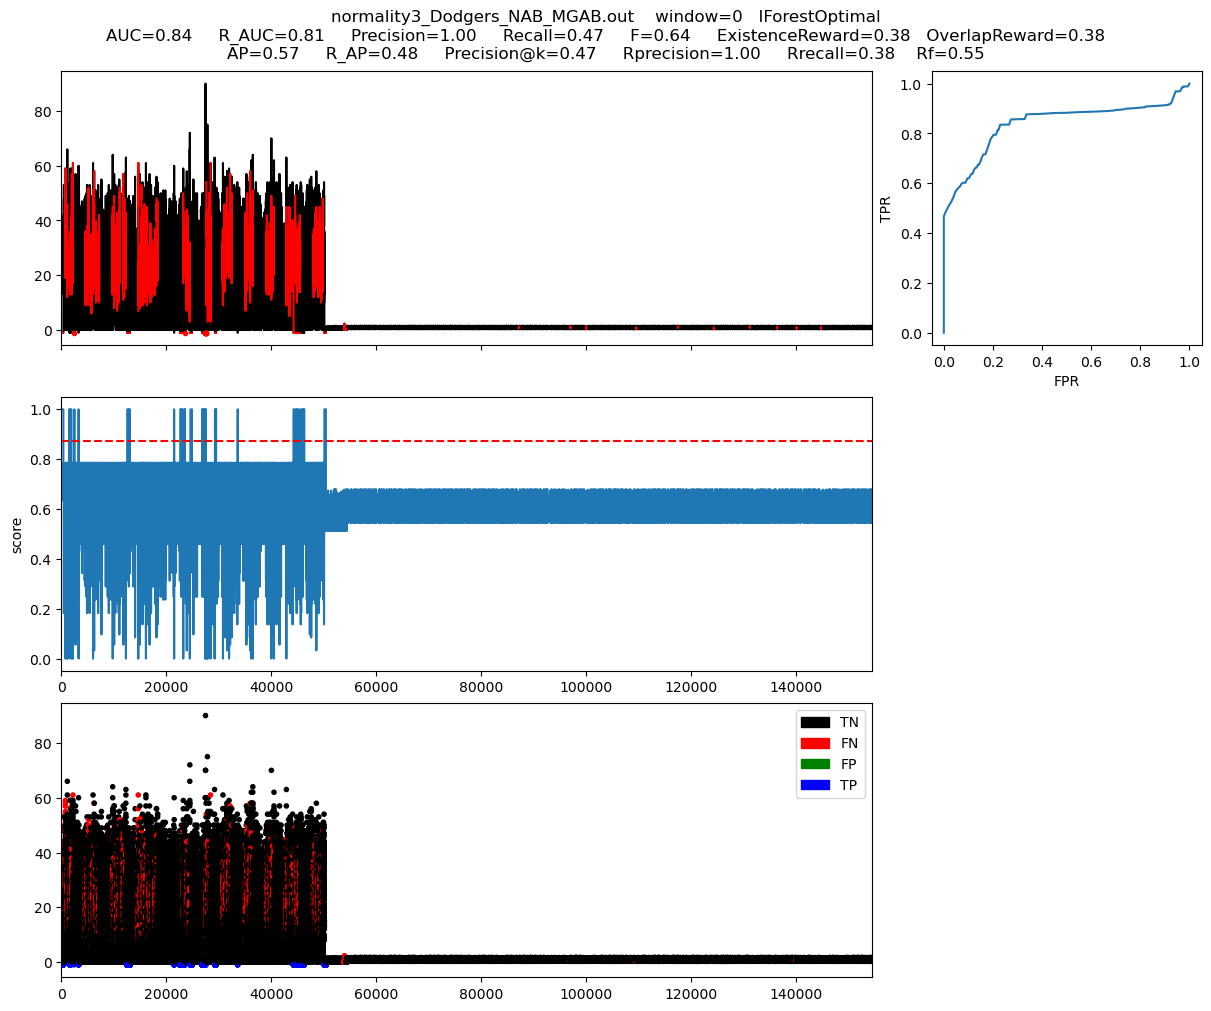



generated_data\normality3_MGAB_Dodgers_NAB.out


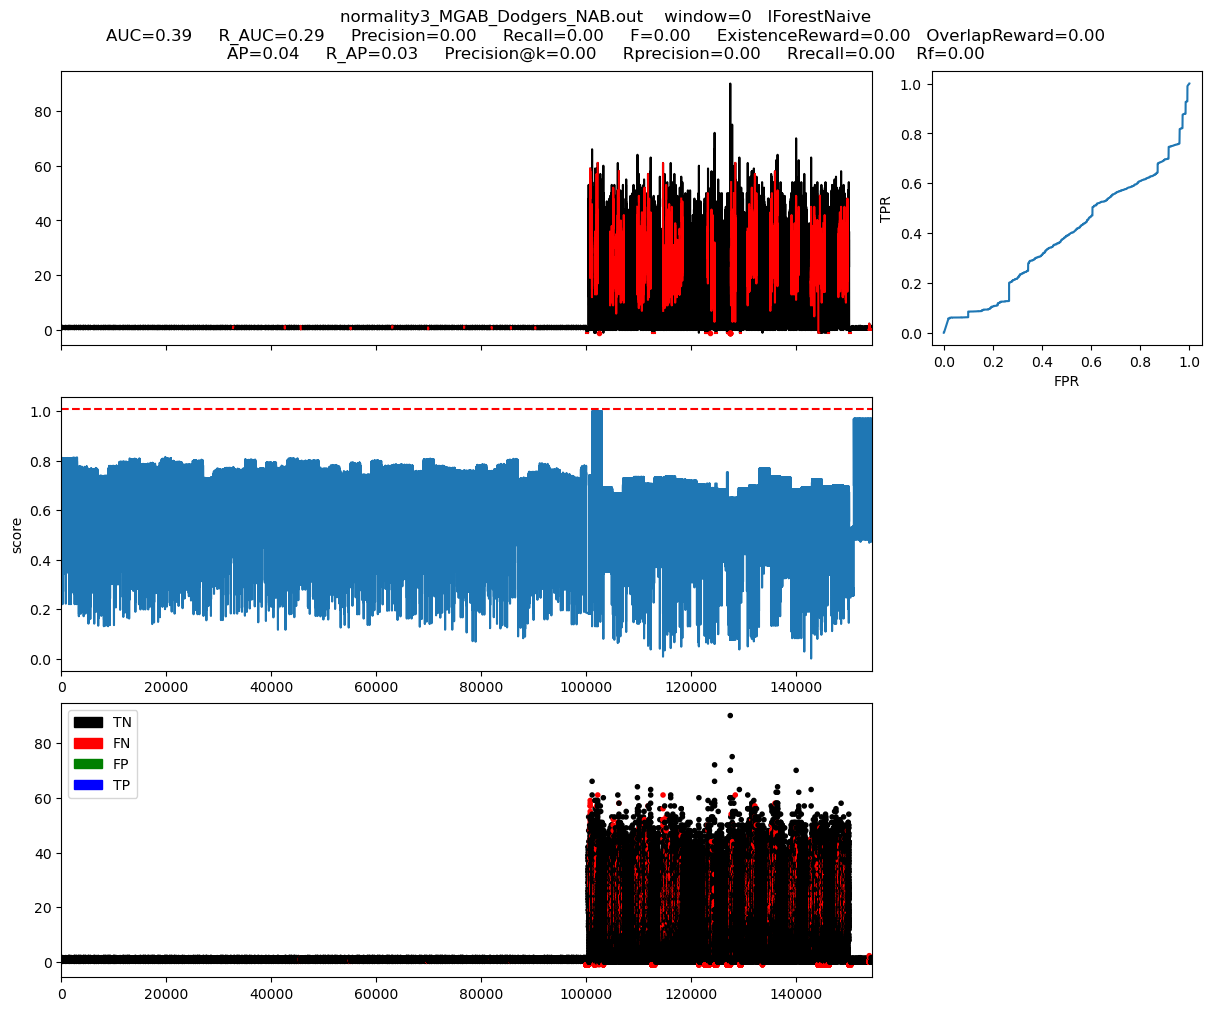

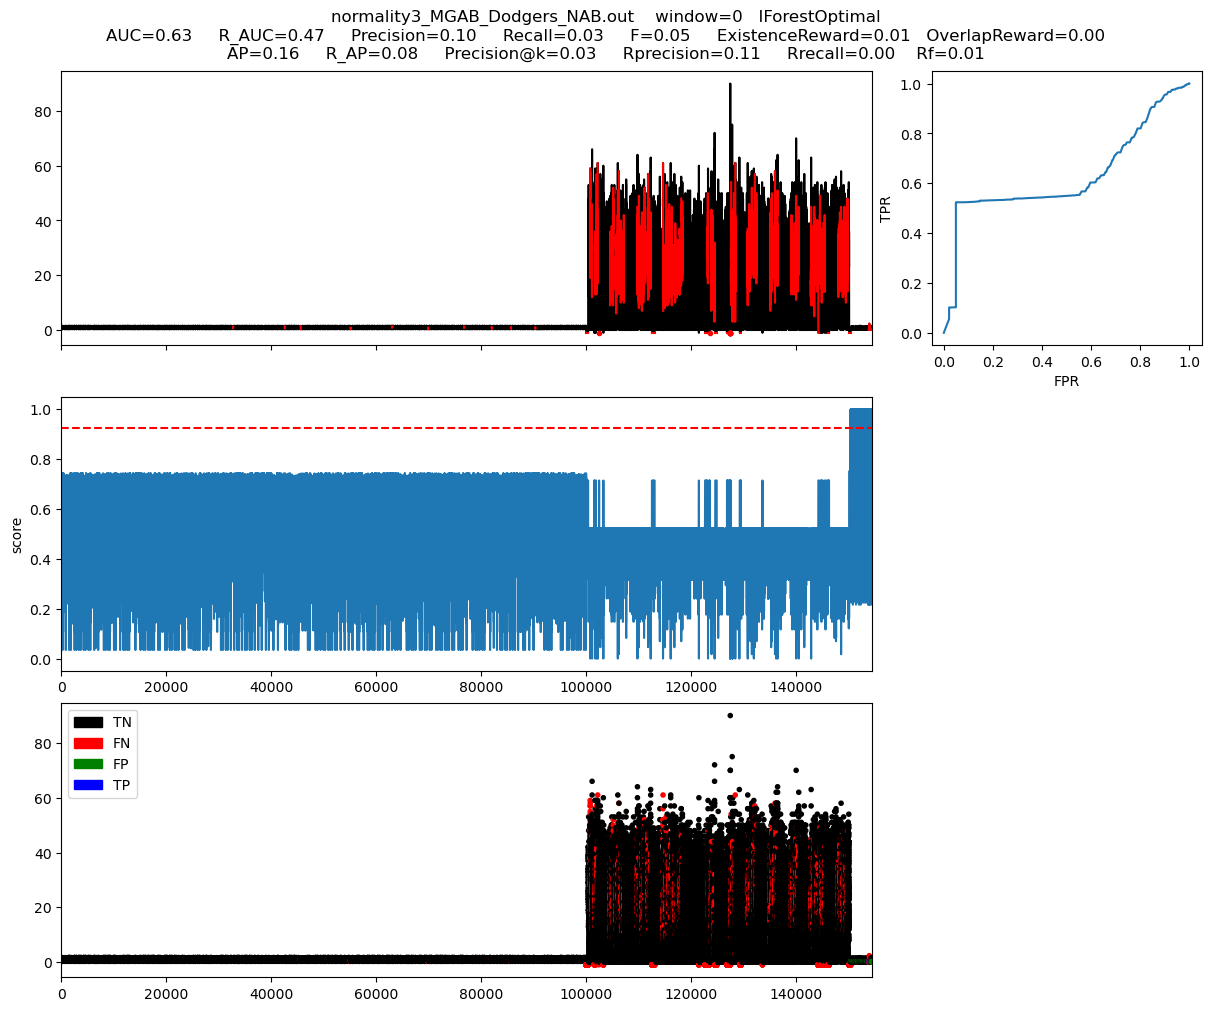



generated_data\normality3_MGAB_NAB_Dodgers.out


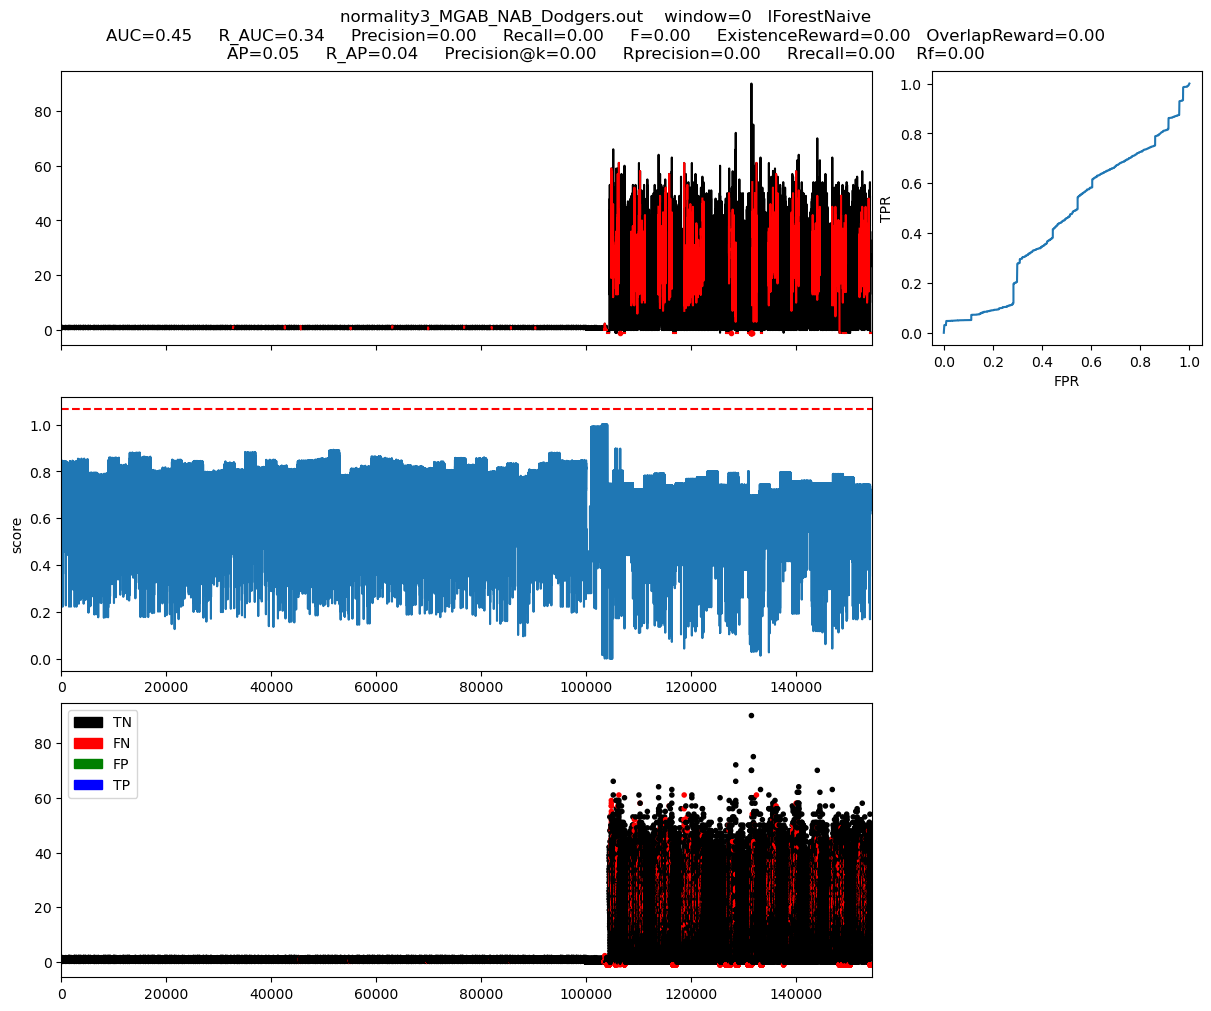

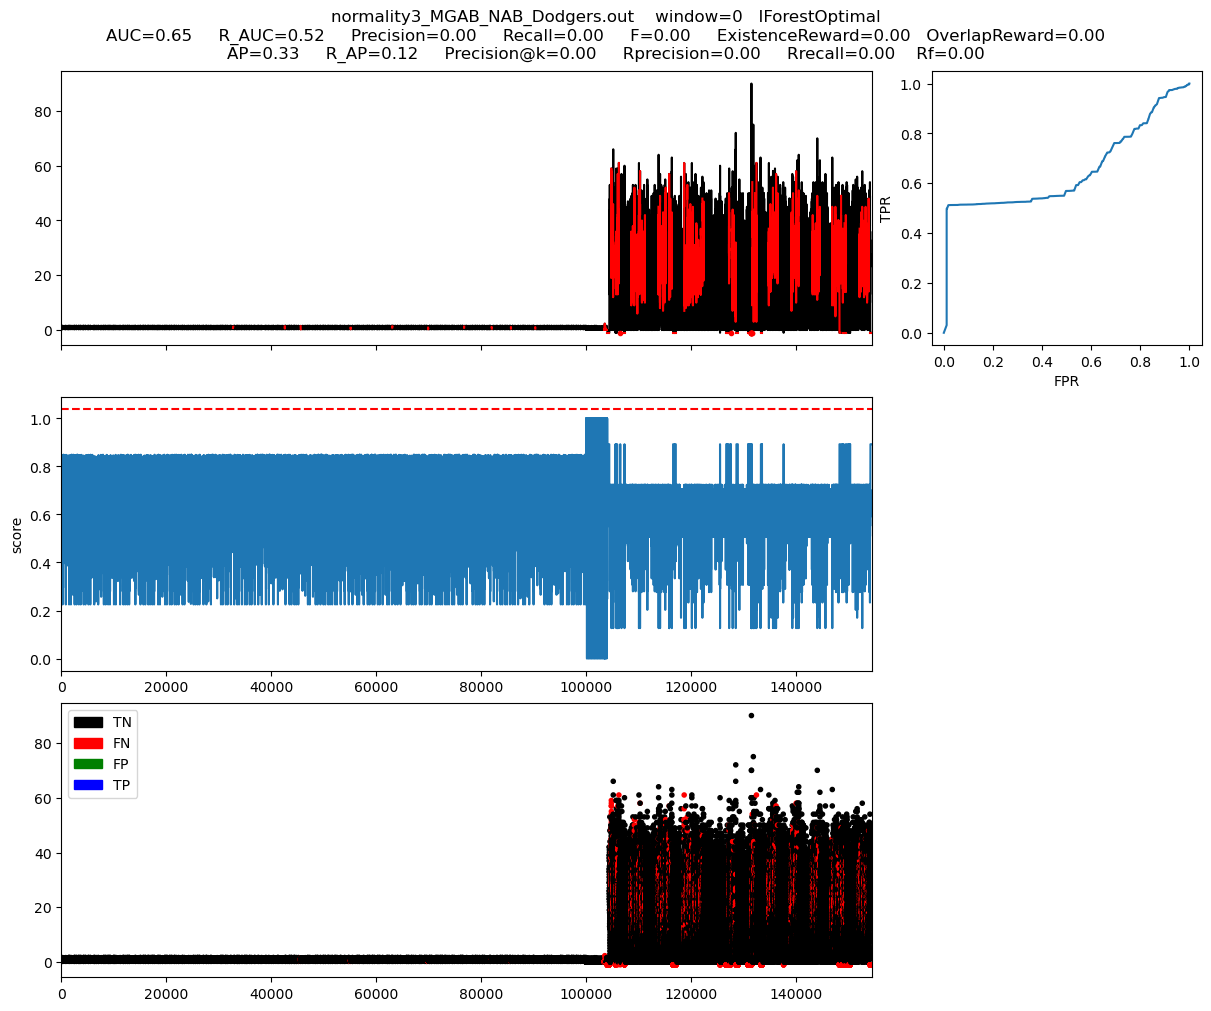



generated_data\normality3_NAB_Dodgers_MGAB.out


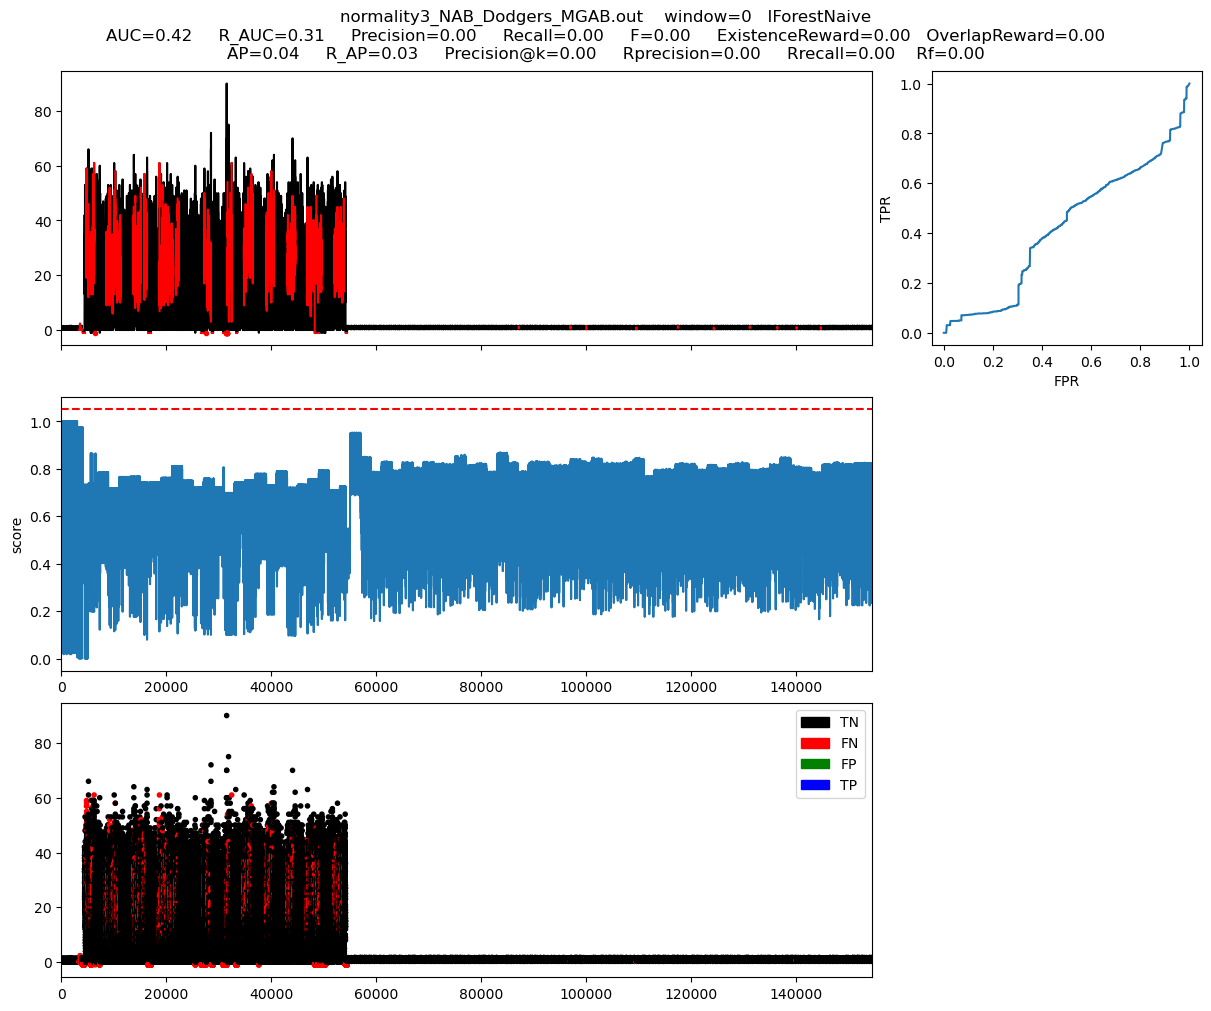

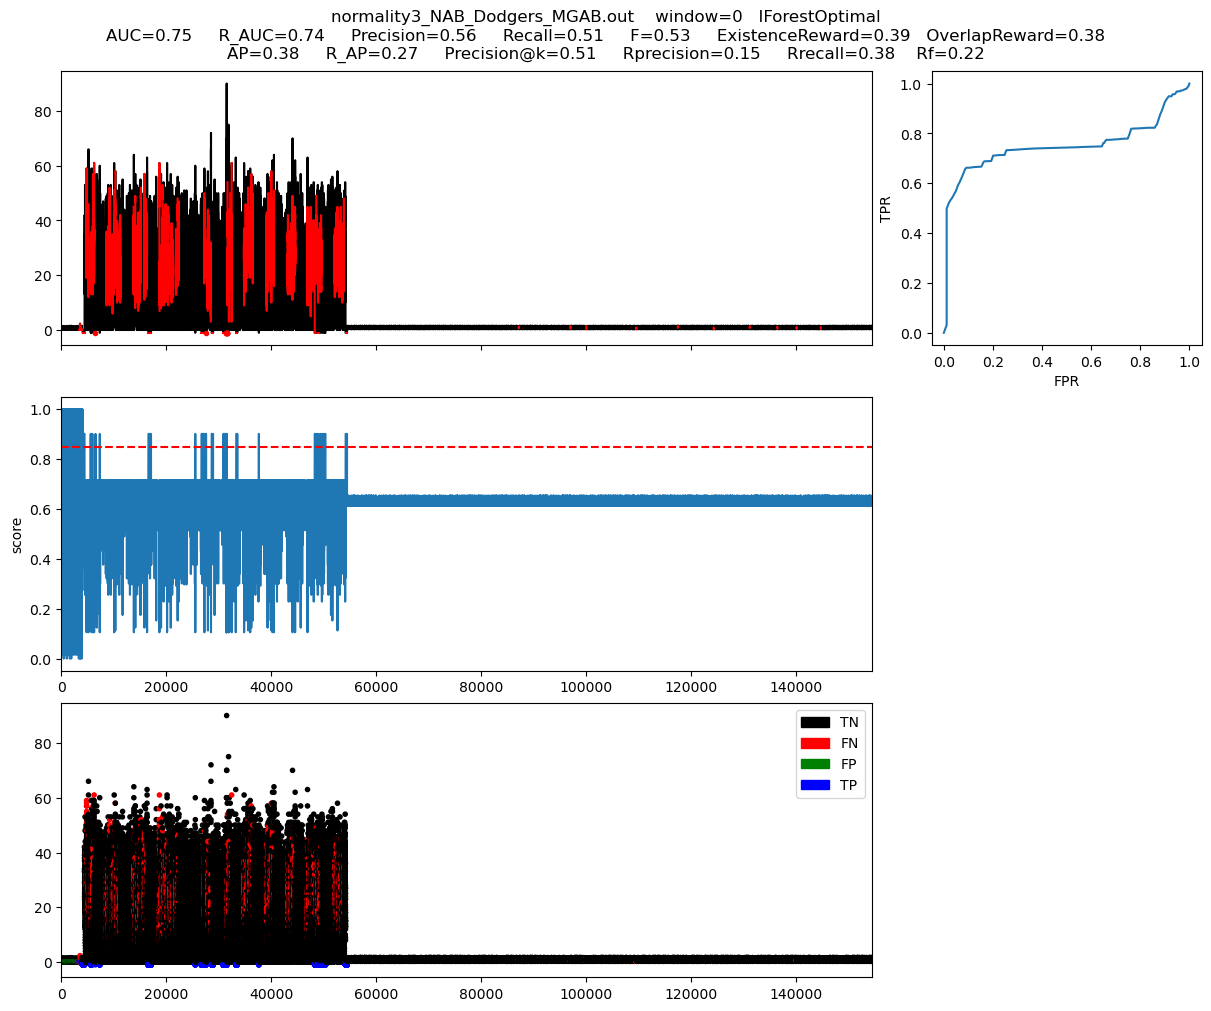



generated_data\normality3_NAB_MGAB_Dodgers.out


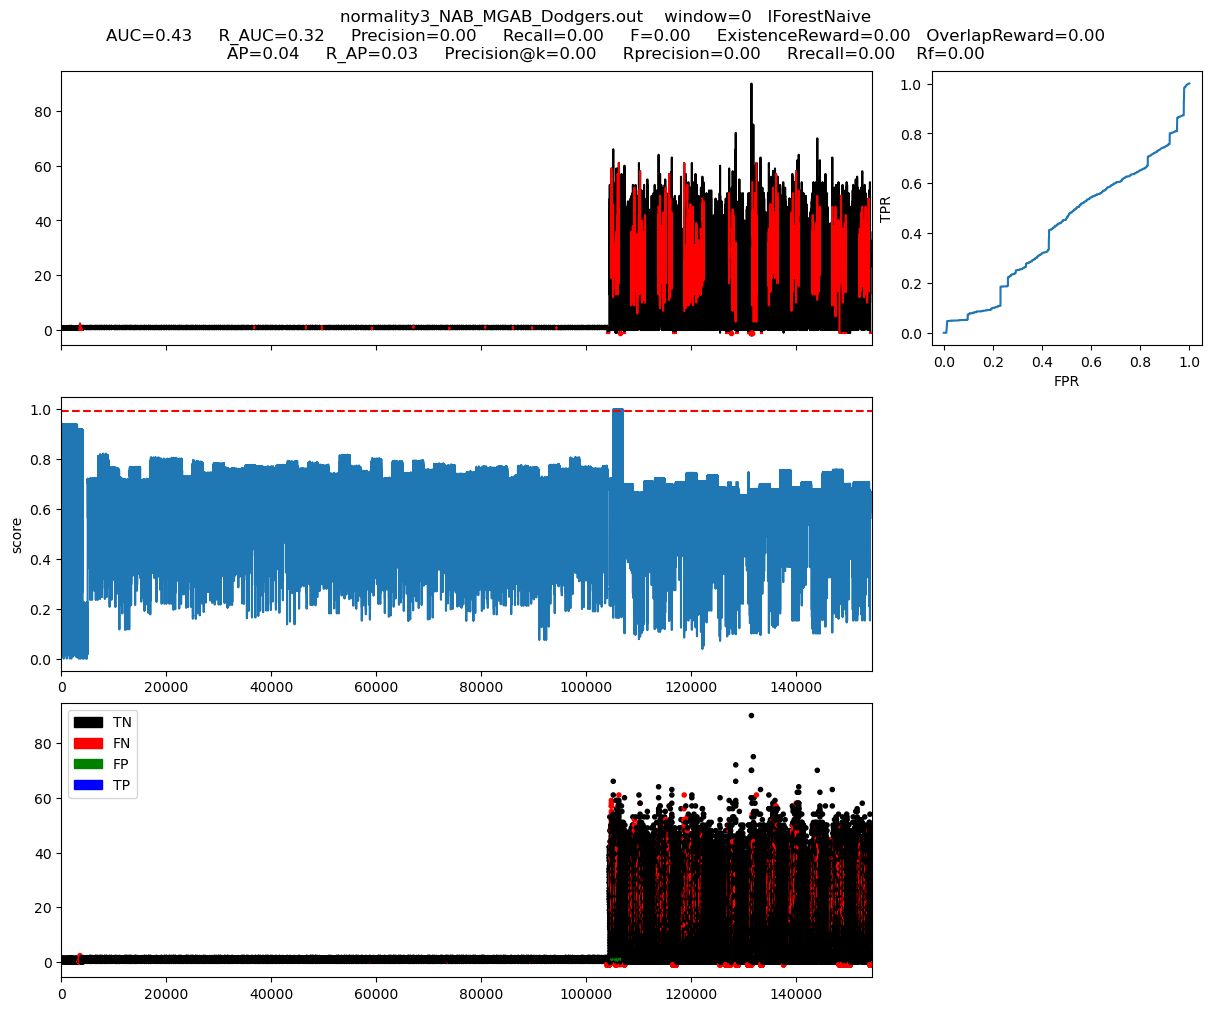

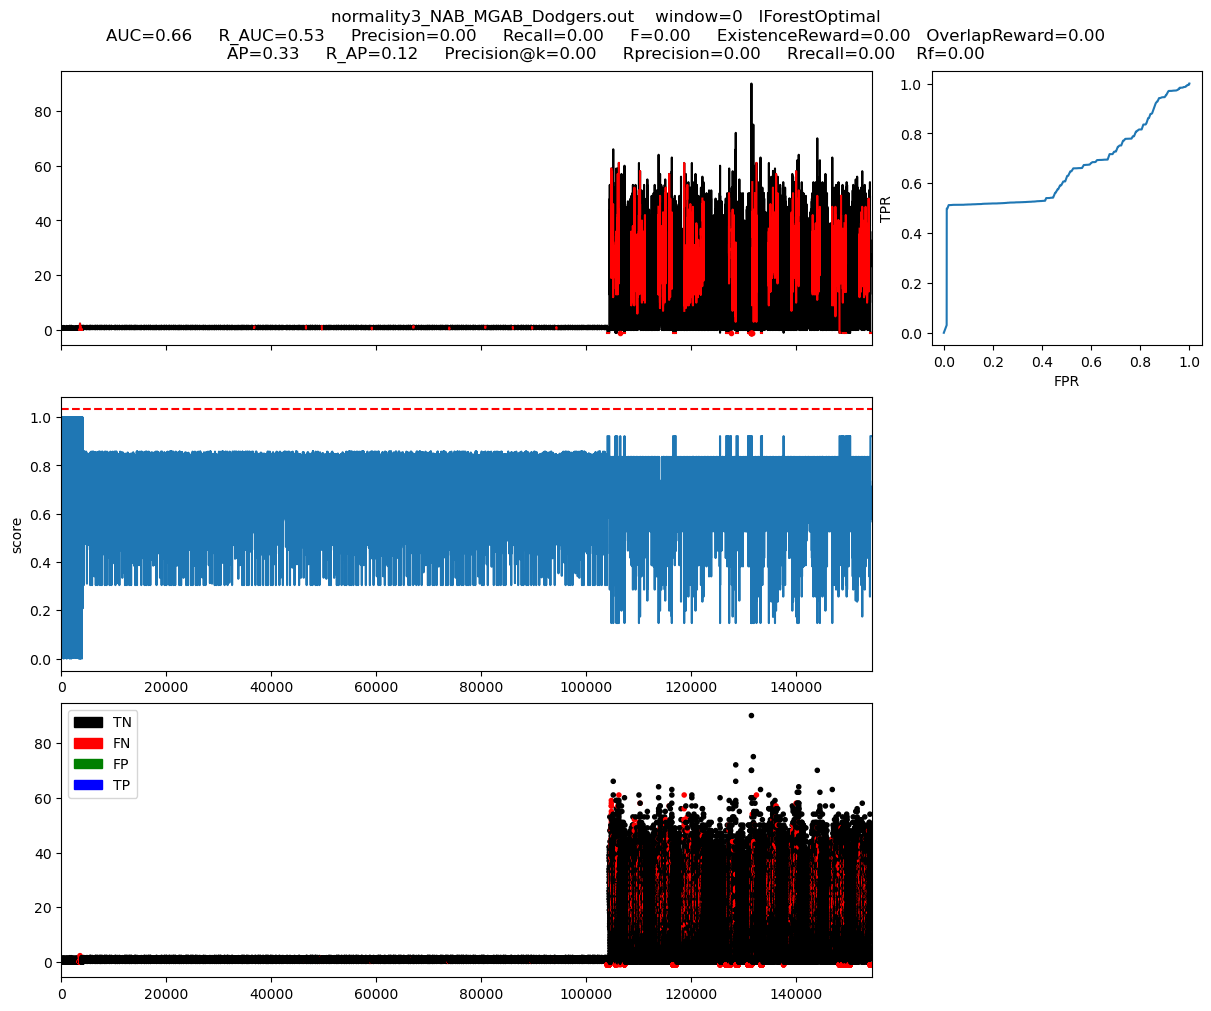

In [1]:
from iforest_naive import IsolationForestNaiveStream
from iforest_optimal import IsolationForestStream
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import iforest_naive
from utils.slidingWindows import plotFig
from sklearn import metrics
import time

directory = 'generated_data/'

compare_df = pd.DataFrame(columns=['file_name', 'name', 'AUC', 'time'])

def update_df(auc, file_name, name, time):
    new_row = {'AUC': auc,
               'file_name': file_name,
               'name': name,
               'time': time}
    compare_df.loc[len(compare_df)] = new_row
    

def iforest_offline():
    model_name = 'IForestOffline'
    clf = IsolationForestNaiveStream()
    x = data
    start_time = time.time()
    clf.fit(x, online=False)
    total_time = time.time() - start_time
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    auc = metrics.roc_auc_score(label, score)
    update_df(auc, name, model_name, total_time)
#     plotFig(data, label, score, 0, fileName=name, modelName=model_name)


def iforest_naive():
    model_name = 'IForestNaive'
    clf = IsolationForestNaiveStream()
    x = data
    start_time = time.time()
    clf.fit(x, init_length=1000, batch_size=2000)
    total_time = time.time() - start_time
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    auc = metrics.roc_auc_score(label, score)
    update_df(auc, name, model_name, total_time)
    plotFig(data, label, score, 0, fileName=name, modelName=model_name)


def iforest_optimal():
    model_name = 'IForestOptimal'
    clf = IsolationForestStream(anomaly_threshold=0.6,
                                                window_size=1000,
                                                drift_threshold=0.5)
    x = data
    start_time = time.time()
    clf.fit(x, init_length=1000)
    total_time = time.time() - start_time
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    auc = metrics.roc_auc_score(label, score)
    update_df(auc, name, model_name, total_time)
    plotFig(data, label, score, 0, fileName=name, modelName=model_name)


for filepath in sorted(Path(directory).iterdir()):
    if filepath.is_file():
        print(filepath)
        name = str(filepath).split('\\')[-1]
    
        df = pd.read_csv(filepath, header=None).dropna().to_numpy()

        max_length = len(df)
        
        data = df[:max_length, 0].astype(float)
        label = df[:max_length, 1].astype(int)
        
        iforest_offline()
        iforest_naive()
        iforest_optimal()
        print()
        print()
                

Below we are going to create a dataframe that has the auc value and execution time for variant 1 and 2 (non-optimal and optimal) as well as the offline iForest method for each file.

In [11]:
# combine auc and time into a single column
compare_df['auc_time'] = compare_df.apply(lambda row: f"{row['AUC']:.3f} /  {row['time']:.3f} sec", axis=1)

pivot_df = compare_df.pivot_table(index='file_name', columns='name', values='auc_time', aggfunc='first').reset_index()

# rename the columns
pivot_df.columns = ['file_name', 'AUC / time (Variation 1)', 'AUC / time (Offline)', 'AUC / time (Variation 2)']

display(pivot_df)

avg_all_files = compare_df.groupby(['name'])['AUC'].mean().reset_index()

print(avg_all_files)

file_name AUC / time (Variation 1)  \
0            normality1_Dodgers.out       0.562 /  3.249 sec   
1               normality1_MGAB.out       0.439 /  7.184 sec   
2                normality1_NAB.out       0.494 /  0.225 sec   
3       normality2_Dodgers_MGAB.out      0.424 /  10.173 sec   
4        normality2_Dodgers_NAB.out       0.542 /  3.609 sec   
5       normality2_MGAB_Dodgers.out      0.395 /  10.160 sec   
6           normality2_MGAB_NAB.out       0.676 /  7.208 sec   
7        normality2_NAB_Dodgers.out       0.563 /  3.546 sec   
8           normality2_NAB_MGAB.out       0.687 /  7.047 sec   
9   normality3_Dodgers_MGAB_NAB.out      0.452 /  10.554 sec   
10  normality3_Dodgers_NAB_MGAB.out      0.460 /  10.351 sec   
11  normality3_MGAB_Dodgers_NAB.out      0.390 /  10.197 sec   
12  normality3_MGAB_NAB_Dodgers.out      0.449 /  10.132 sec   
13  normality3_NAB_Dodgers_MGAB.out      0.421 /  10.216 sec   
14  normality3_NAB_MGAB_Dodgers.out      0.426 /  10.795 sec   

   AUC / time (Offline) AUC / time (Variation 2)  
0    0.637 /  1.396 sec       0.779 /  1.349 sec  
1    0.537 /  2.811 sec       0.459 /  2.757 sec  
2    0.505 /  0.145 sec       0.495 /  0.115 sec  
3    0.882 /  4.057 sec       0.795 /  3.277 sec  
4    0.636 /  1.532 sec       0.779 /  1.436 sec  
5    0.876 /  4.049 sec       0.652 /  4.157 sec  
6    0.819 /  2.706 sec       0.689 /  2.918 sec  
7    0.639 /  1.494 sec       0.750 /  1.489 sec  
8    0.817 /  2.688 sec       0.652 /  2.854 sec  
9    0.874 /  4.269 sec       0.779 /  3.294 sec  
10   0.877 /  4.217 sec       0.838 /  3.377 sec  
11   0.875 /  4.143 sec       0.630 /  4.162 sec  
12   0.880 /  4.192 sec       0.652 /  4.162 sec  
13   0.884 /  4.267 sec       0.751 /  3.314 sec  
14   0.875 /  4.310 sec       0.658 /  4.332 sec

             name       AUC
0    IForestNaive  0.492034
1  IForestOffline  0.774284
2  IForestOptimal  0.690492


Below we will find the average AUC value and execution time for the different normalities

In [12]:
# Function to assign normality
def assign_normality(file_name):
    if file_name.startswith('normality1'):
        return 'normality1'
    elif file_name.startswith('normality2'):
        return 'normality2'
    elif file_name.startswith('normality3'):
        return 'normality3'

compare_df['normality'] = compare_df['file_name'].apply(assign_normality)

# group by normality and name and calculate the mean value of AUC and time
result = compare_df.groupby(['normality', 'name']).agg({'AUC': 'mean', 'time': 'mean'}).reset_index()

pivot_table = result.pivot(index='normality', columns='name').reset_index()

pivot_table.columns = ['normality', 'AUC_Naive','AUC_Offline', 'AUC_Optimal', 'time_Naive','time_Offline', 'time_Optimal']

pivot_table['AUC/time (Offline)'] = pivot_table.apply(lambda row: f"{row['AUC_Offline']:.3f} / {row['time_Offline']:.3f} sec", axis=1)
pivot_table['AUC/time (variation 1)'] = pivot_table.apply(lambda row: f"{row['AUC_Naive']:.3f} / {row['time_Naive']:.3f} sec", axis=1)
pivot_table['AUC/time (variation 2)'] = pivot_table.apply(lambda row: f"{row['AUC_Optimal']:.3f} / {row['time_Optimal']:.3f} sec", axis=1)

pivot_table = pivot_table[['normality', 'AUC/time (Offline)', 'AUC/time (variation 1)', 'AUC/time (variation 2)']]

display(pivot_table)


normality AUC/time (Offline) AUC/time (variation 1) AUC/time (variation 2)
0  normality1  0.560 / 1.451 sec      0.498 / 3.553 sec      0.577 / 1.407 sec
1  normality2  0.778 / 2.754 sec      0.548 / 6.957 sec      0.720 / 2.688 sec
2  normality3  0.878 / 4.233 sec     0.433 / 10.374 sec      0.718 / 3.773 sec